For 100% dataset


NAIVE BAYES - WITH PREPROCESSING:

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100%|██████████| 50/50 [00:01<00:00, 35.08trial/s, best loss: -0.8222222222222223]
Training Data Metrics:
Accuracy: 0.9761538461538461
Precision: 0.9977116704805492
Recall: 0.8257575757575758
F1-Score: 0.9036269430051814
AUC: 0.9127305079262374
RMSE: 0.15442199922988256


Testing Data Metrics:
Accuracy: 0.9611244019138756
Precision: 1.0
Recall: 0.7031963470319634
F1-Score: 0.8257372654155496
AUC: 0.8515981735159817
RMSE: 0.197168958221431


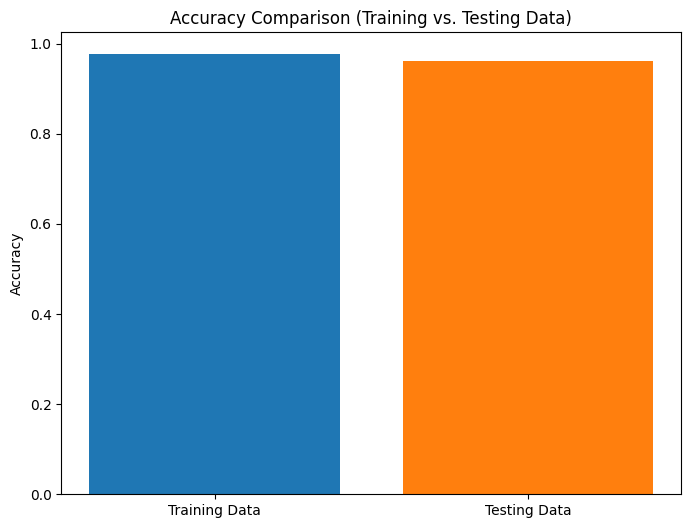

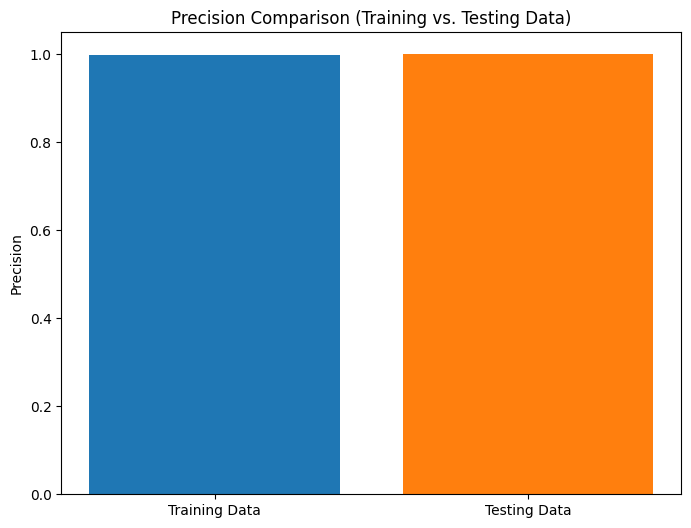

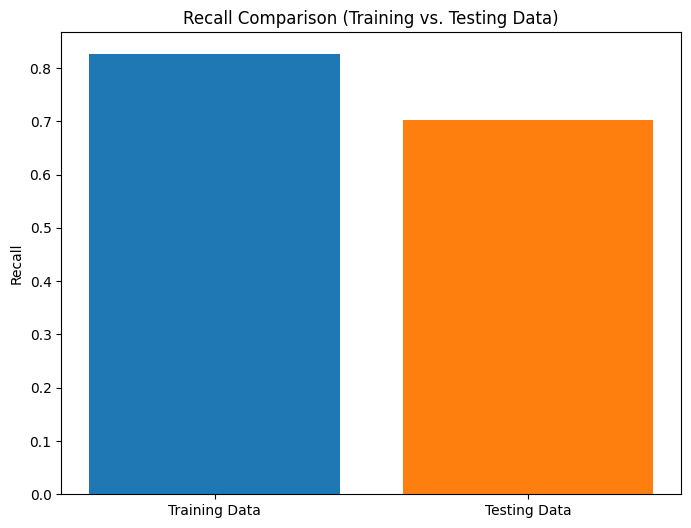

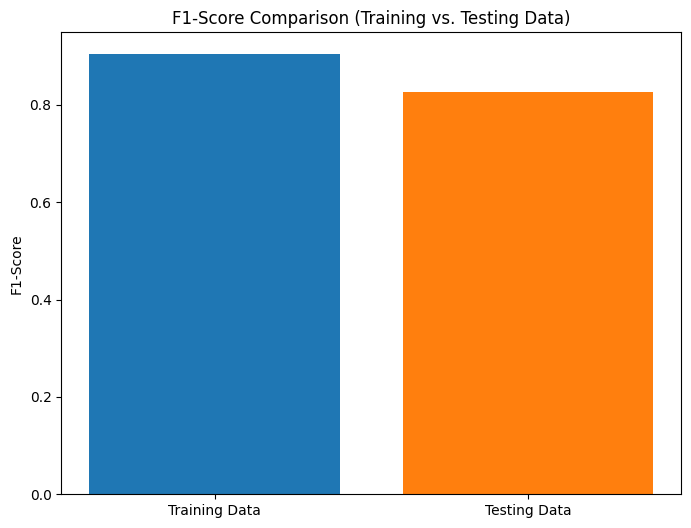

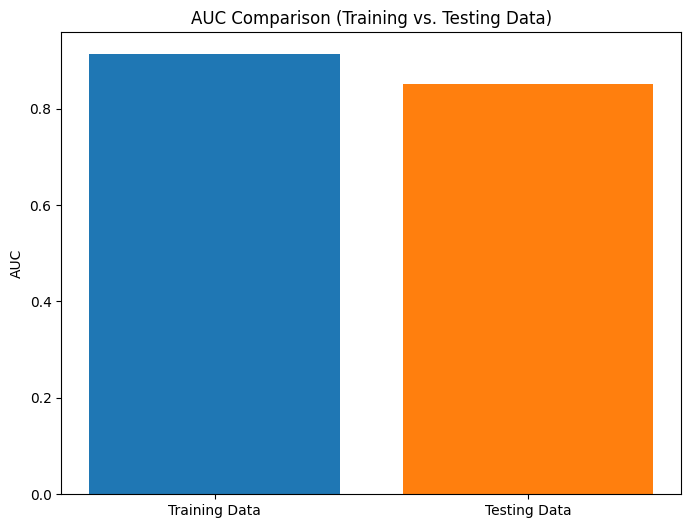

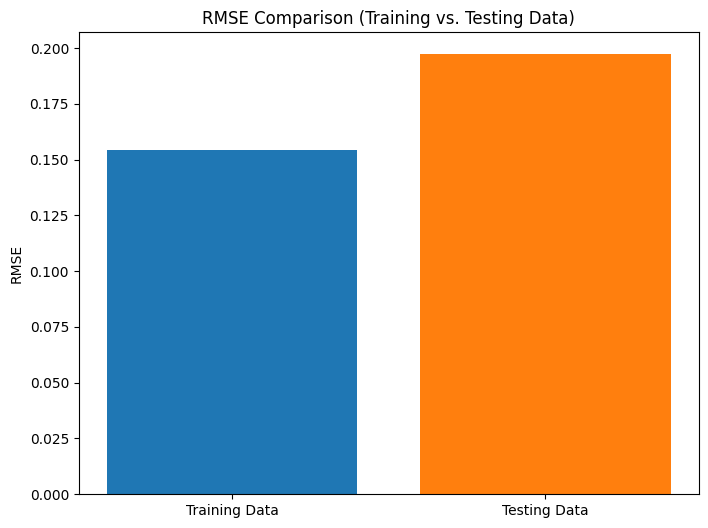

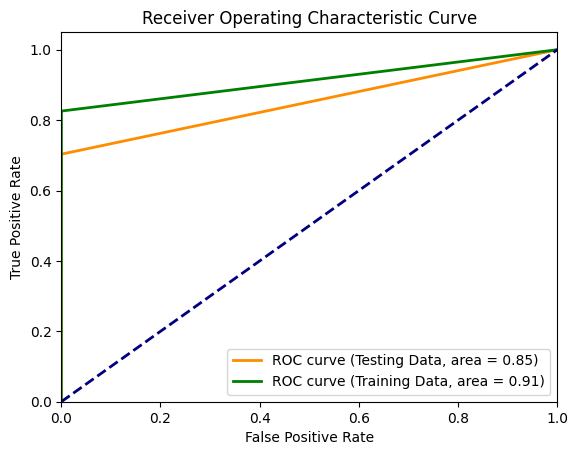

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, mean_squared_error
)
from hyperopt import fmin, tpe, hp, Trials
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Step 1: Load the dataset
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

# Step 2: Data Preprocessing
# Remove special characters and numbers
data['message'] = data['message'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
data['message'] = data['message'].apply(lambda x: re.sub(r'\d+', '', x))

# Tokenize and vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words=stopwords.words('english')
)

# Stemming
stemmer = PorterStemmer()
data['message'] = data['message'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Split the data into 70% training and 30% testing
X = data['message']
y = data['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Tokenize and vectorize the text using TF-IDF (fit only on training data)
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words=stopwords.words('english')
)

X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

# Define the objective function
def objective(params):
    model = MultinomialNB(
        alpha=params['alpha']
    )

    # Use cross_val_predict to obtain predicted labels for evaluation
    predicted_labels = cross_val_predict(model, X_train, y_train, cv=5)

    # Calculate evaluation metrics
    f1 = f1_score(y_train, predicted_labels)

    # AUC
    roc_auc = roc_auc_score(y_train, predicted_labels)

    # Confusion Matrix
    cm = confusion_matrix(y_train, predicted_labels)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_train, predicted_labels))

    # Define the objective to maximize (e.g., F1-score)
    return -f1  # Minimize negative F1-score

# Set the Hyperparameter Search Space
space = {
    'alpha': hp.loguniform('alpha', 1e-10, 1e-1),
}

# Initialize trials to keep track of optimization history
trials = Trials()

# Perform Bayesian optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Extract the best hyperparameters
best_alpha = best['alpha']
# Train the final Naive Bayes model with the best hyperparameters on the full training data
final_model = MultinomialNB(alpha=best_alpha)
final_model.fit(X_train, y_train)

# Evaluate the final model on the testing data and calculate evaluation metrics
predicted_labels_test = final_model.predict(X_test)
accuracy_test = accuracy_score(y_test, predicted_labels_test)
precision_test = precision_score(y_test, predicted_labels_test)
recall_test = recall_score(y_test, predicted_labels_test)
f1_test = f1_score(y_test, predicted_labels_test)

# Calculate AUC, Confusion Matrix, and RMSE for testing data
roc_auc_test = roc_auc_score(y_test, predicted_labels_test)
cm_test = confusion_matrix(y_test, predicted_labels_test)
rmse_test = np.sqrt(mean_squared_error(y_test, predicted_labels_test))

# Calculate evaluation metrics for training data directly
predicted_labels_train = final_model.predict(X_train)
accuracy_train = accuracy_score(y_train, predicted_labels_train)
precision_train = precision_score(y_train, predicted_labels_train)
recall_train = recall_score(y_train, predicted_labels_train)
f1_train = f1_score(y_train, predicted_labels_train)

# Calculate AUC, Confusion Matrix, and RMSE for training data
roc_auc_train = roc_auc_score(y_train, predicted_labels_train)
cm_train = confusion_matrix(y_train, predicted_labels_train)
rmse_train = np.sqrt(mean_squared_error(y_train, predicted_labels_train))

# Define evaluation metrics for training and testing data
train_metrics = {
    'Accuracy': accuracy_train,
    'Precision': precision_train,
    'Recall': recall_train,
    'F1-Score': f1_train,
    'AUC': roc_auc_train,
    'RMSE': rmse_train
}

test_metrics = {
    'Accuracy': accuracy_test,
    'Precision': precision_test,
    'Recall': recall_test,
    'F1-Score': f1_test,
    'AUC': roc_auc_test,
    'RMSE': rmse_test
}
# Print the evaluation metrics for training data
print("Training Data Metrics:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1-Score:", f1_train)
print("AUC:", roc_auc_train)
print("RMSE:", rmse_train)
print("\n")

# Print the evaluation metrics for testing data
print("Testing Data Metrics:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-Score:", f1_test)
print("AUC:", roc_auc_test)
print("RMSE:", rmse_test)

# Plot each metric separately
for metric_name, values in train_metrics.items():
    plt.figure(figsize=(8, 6))
    plt.bar(['Training Data'], [train_metrics[metric_name]])
    plt.bar(['Testing Data'], [test_metrics[metric_name]])
    plt.title(f'{metric_name} Comparison (Training vs. Testing Data)')
    plt.ylabel(metric_name)
    plt.show()

# Plot the ROC curve for both training and testing data
fpr_test, tpr_test, _ = roc_curve(y_test, predicted_labels_test)
fpr_train, tpr_train, _ = roc_curve(y_train, predicted_labels_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (Testing Data, area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='green', lw=2, label='ROC curve (Training Data, area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()



NAIVE BAYES - WITHOUT PREPROCESSING

100%|██████████| 50/50 [00:03<00:00, 14.13trial/s, best loss: -0.8753993610223643]
Training Data Metrics:
Accuracy: 0.985897435897436
Precision: 1.0
Recall: 0.8958333333333334
F1-Score: 0.945054945054945
AUC: 0.9479166666666667
RMSE: 0.11875421719907088


Testing Data Metrics:
Accuracy: 0.9694976076555024
Precision: 1.0
Recall: 0.7671232876712328
F1-Score: 0.8682170542635659
AUC: 0.8835616438356164
RMSE: 0.17464934109379746


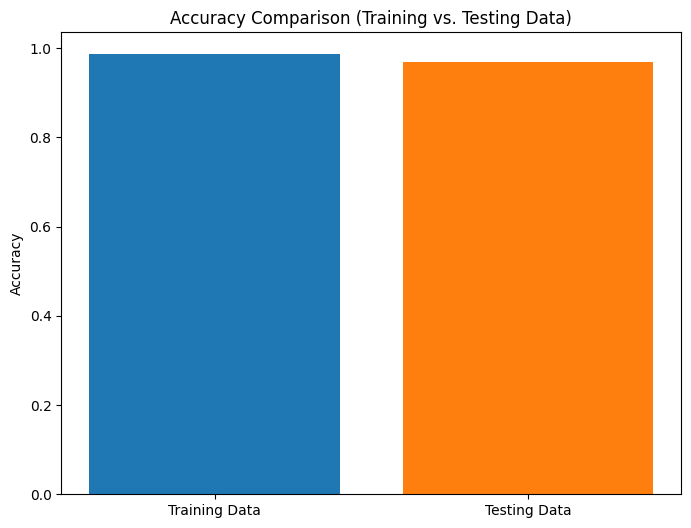

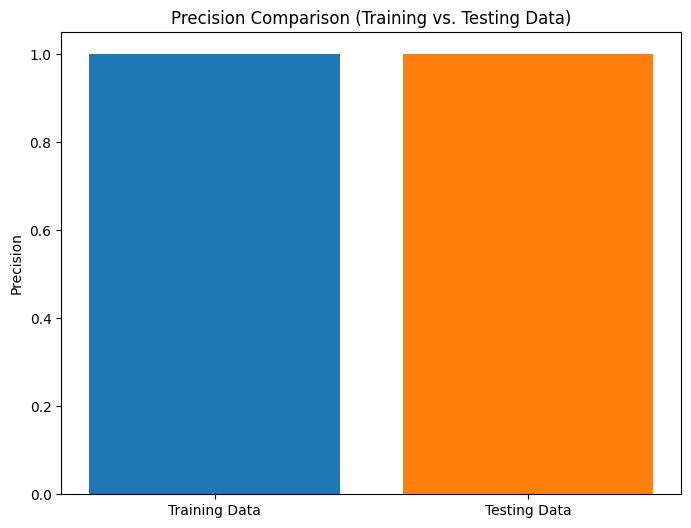

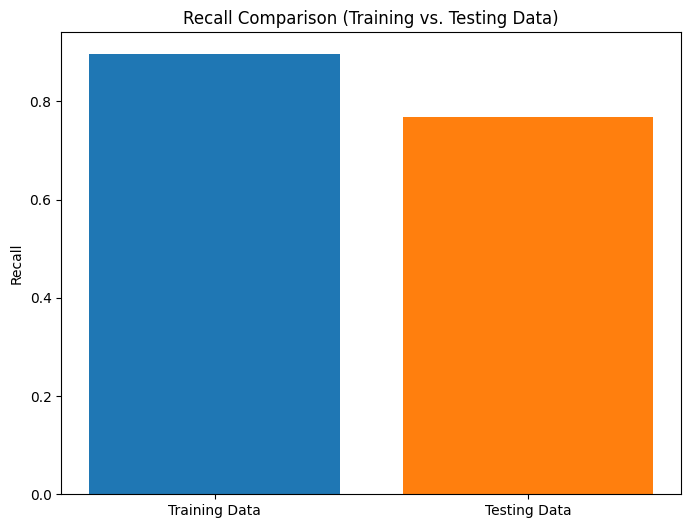

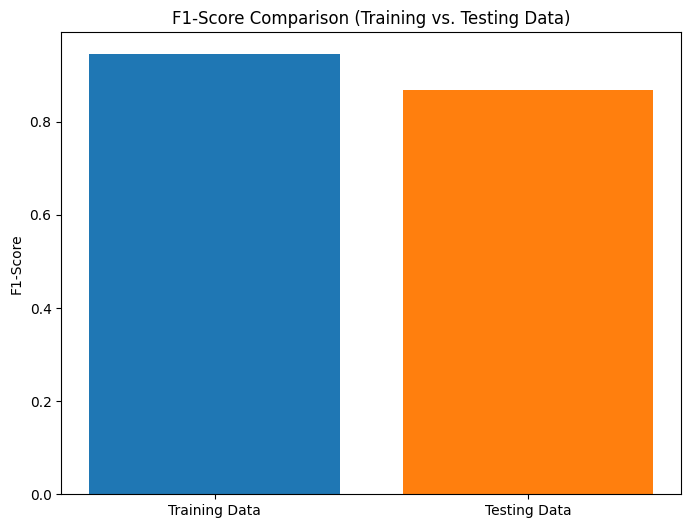

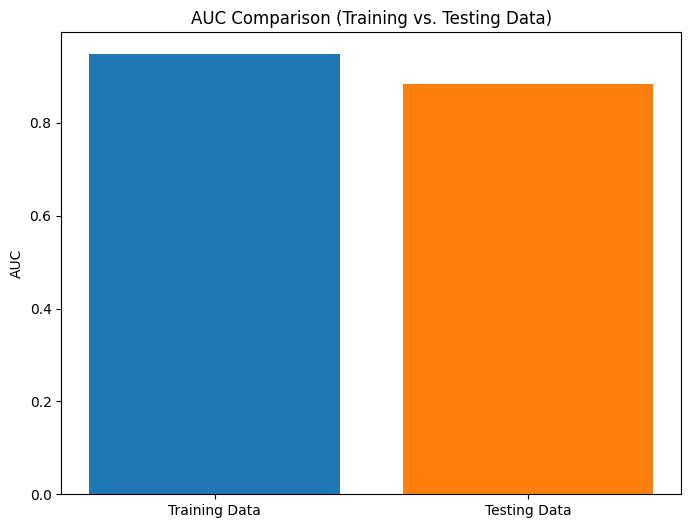

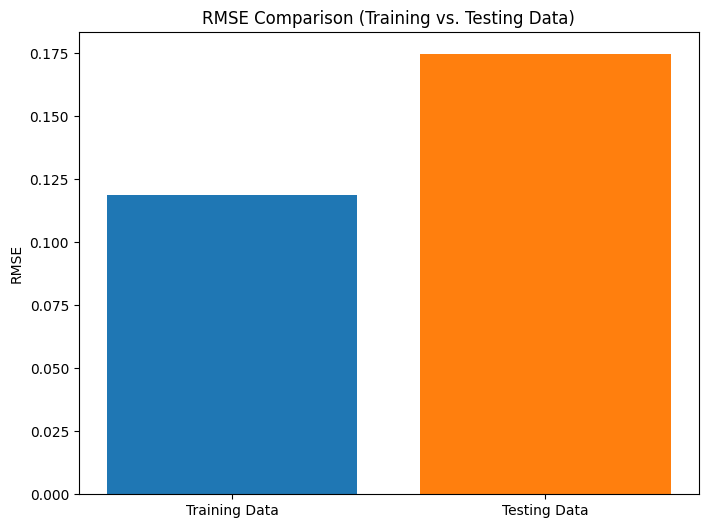

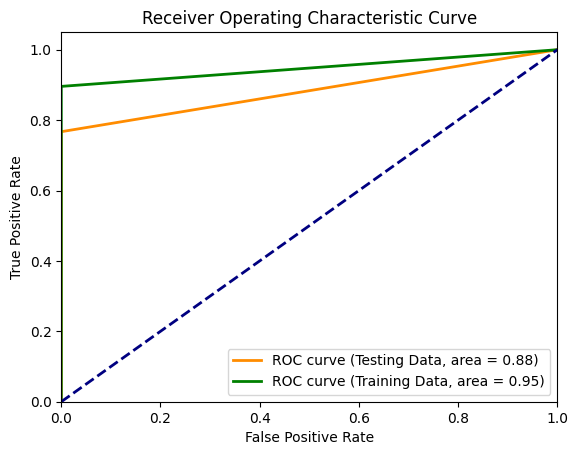

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, mean_squared_error
)
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Step 1: Load the dataset
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

# Split the data into 70% training and 30% testing
X = data['message']
y = data['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Tokenize and vectorize the text using TF-IDF (fit only on training data)
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

# Define the objective function
def objective(params):
    model = MultinomialNB(
        alpha=params['alpha']
    )

    # Use cross_val_predict to obtain predicted labels for evaluation
    predicted_labels = cross_val_predict(model, X_train, y_train, cv=5)

    # Calculate evaluation metrics
    f1 = f1_score(y_train, predicted_labels)

    # AUC
    roc_auc = roc_auc_score(y_train, predicted_labels)

    # Confusion Matrix
    cm = confusion_matrix(y_train, predicted_labels)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_train, predicted_labels))

    # Define the objective to maximize (e.g., F1-score)
    return -f1  # Minimize negative F1-score

# Set the Hyperparameter Search Space
space = {
    'alpha': hp.loguniform('alpha', 1e-10, 1e-1),
}

# Initialize trials to keep track of optimization history
trials = Trials()

# Perform Bayesian optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Extract the best hyperparameters
best_alpha = best['alpha']

# Train the final Naive Bayes model with the best hyperparameters on the full training data
final_model = MultinomialNB(alpha=best_alpha)
final_model.fit(X_train, y_train)

# Evaluate the final model on the testing data and calculate evaluation metrics
predicted_labels_test = final_model.predict(X_test)
accuracy_test = accuracy_score(y_test, predicted_labels_test)
precision_test = precision_score(y_test, predicted_labels_test)
recall_test = recall_score(y_test, predicted_labels_test)
f1_test = f1_score(y_test, predicted_labels_test)

# Calculate AUC, Confusion Matrix, and RMSE for testing data
roc_auc_test = roc_auc_score(y_test, predicted_labels_test)
cm_test = confusion_matrix(y_test, predicted_labels_test)
rmse_test = np.sqrt(mean_squared_error(y_test, predicted_labels_test))

# Calculate evaluation metrics for training data directly
predicted_labels_train = final_model.predict(X_train)
accuracy_train = accuracy_score(y_train, predicted_labels_train)
precision_train = precision_score(y_train, predicted_labels_train)
recall_train = recall_score(y_train, predicted_labels_train)
f1_train = f1_score(y_train, predicted_labels_train)

# Calculate AUC, Confusion Matrix, and RMSE for training data
roc_auc_train = roc_auc_score(y_train, predicted_labels_train)
cm_train = confusion_matrix(y_train, predicted_labels_train)
rmse_train = np.sqrt(mean_squared_error(y_train, predicted_labels_train))

# Define evaluation metrics for training and testing data
train_metrics = {
    'Accuracy': accuracy_train,
    'Precision': precision_train,
    'Recall': recall_train,
    'F1-Score': f1_train,
    'AUC': roc_auc_train,
    'RMSE': rmse_train
}

test_metrics = {
    'Accuracy': accuracy_test,
    'Precision': precision_test,
    'Recall': recall_test,
    'F1-Score': f1_test,
    'AUC': roc_auc_test,
    'RMSE': rmse_test
}

# Print the evaluation metrics for training data
print("Training Data Metrics:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1-Score:", f1_train)
print("AUC:", roc_auc_train)
print("RMSE:", rmse_train)
print("\n")

# Print the evaluation metrics for testing data
print("Testing Data Metrics:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-Score:", f1_test)
print("AUC:", roc_auc_test)
print("RMSE:", rmse_test)

# Plot each metric separately
for metric_name, values in train_metrics.items():
    plt.figure(figsize=(8, 6))
    plt.bar(['Training Data'], [train_metrics[metric_name]])
    plt.bar(['Testing Data'], [test_metrics[metric_name]])
    plt.title(f'{metric_name} Comparison (Training vs. Testing Data)')
    plt.ylabel(metric_name)
    plt.show()

# Plot the ROC curve for both training and testing data
fpr_test, tpr_test, _ = roc_curve(y_test, predicted_labels_test)
fpr_train, tpr_train, _ = roc_curve(y_train, predicted_labels_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (Testing Data, area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='green', lw=2, label='ROC curve (Training Data, area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()




RANDOM FOREST - WITH PREPROCESSING

100%|██████████| 50/50 [07:01<00:00,  8.44s/trial, best loss: -0.7972665148063781]
Training Data Metrics:
Accuracy: 0.9666666666666667
Precision: 1.0
Recall: 0.7537878787878788
F1-Score: 0.8596112311015118
AUC: 0.8768939393939394
RMSE: 0.18257418583505536


Testing Data Metrics:
Accuracy: 0.9521531100478469
Precision: 1.0
Recall: 0.634703196347032
F1-Score: 0.776536312849162
AUC: 0.817351598173516
RMSE: 0.21873931962990356


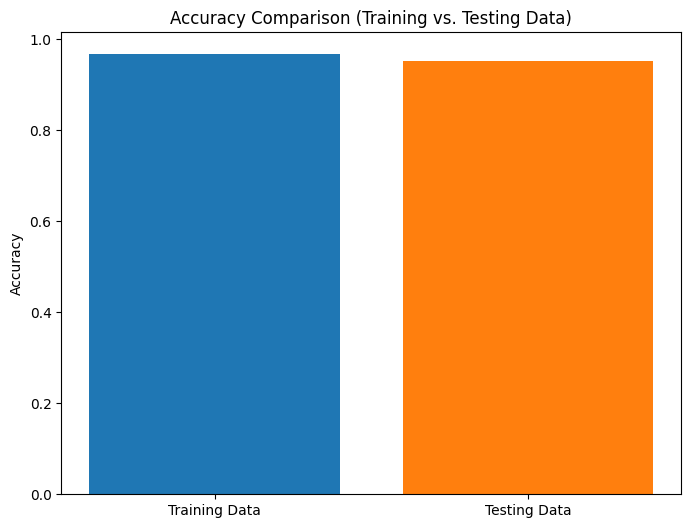

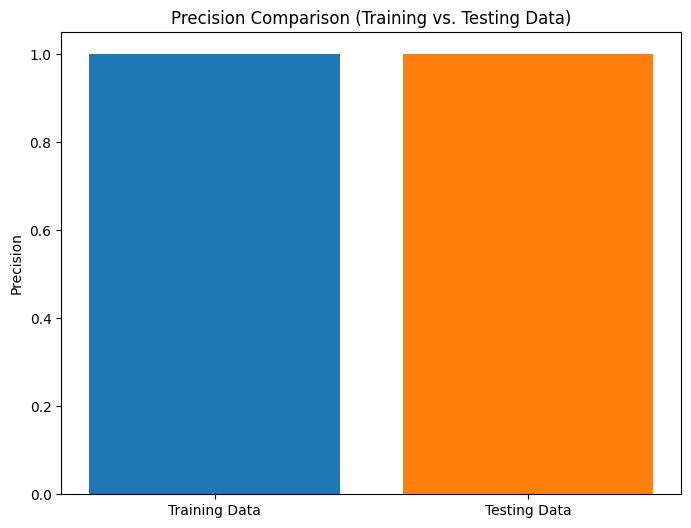

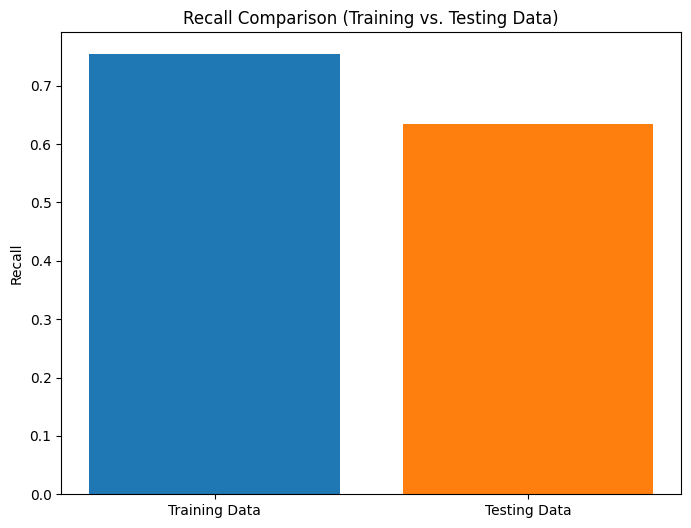

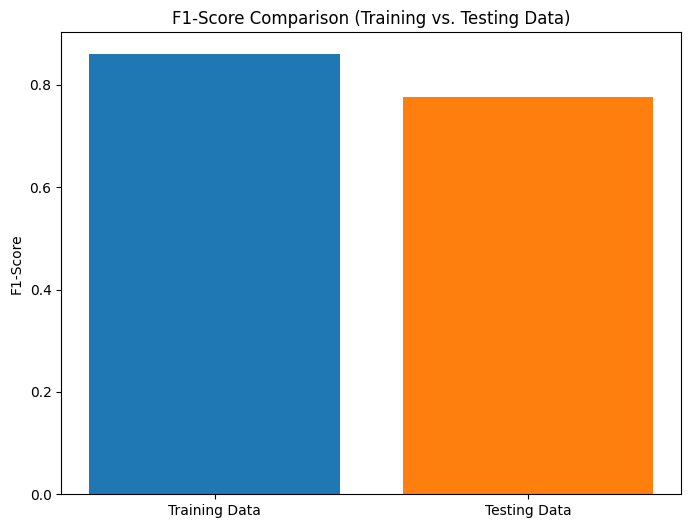

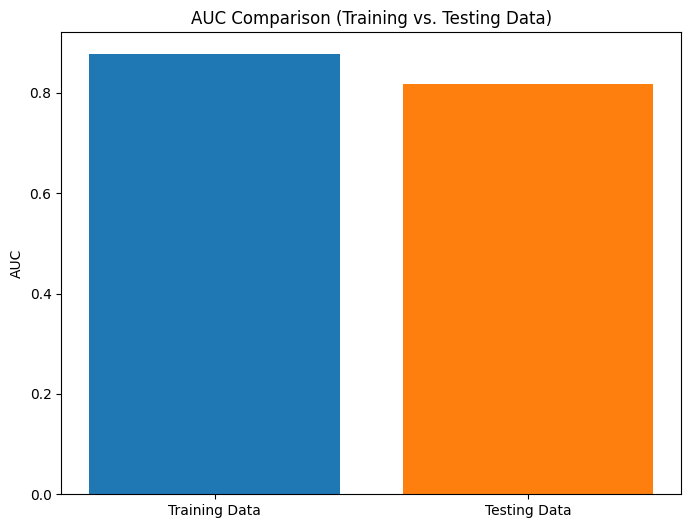

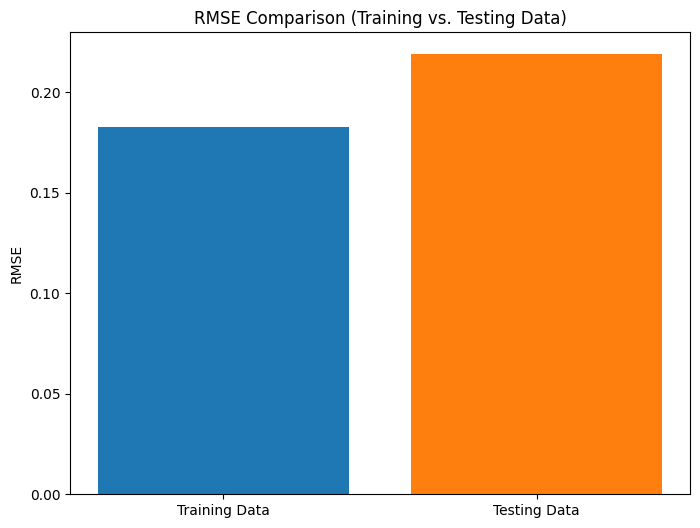

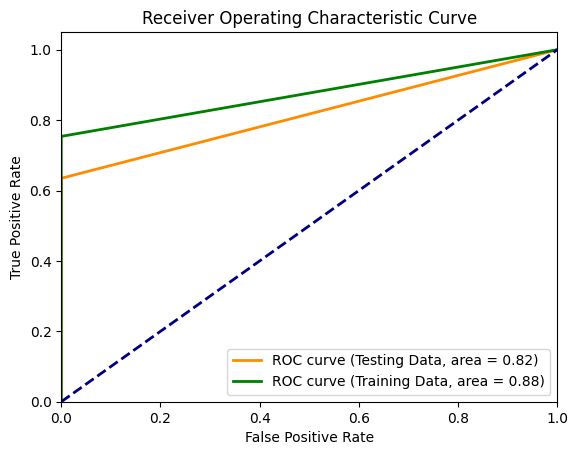

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from hyperopt import fmin, tpe, hp, Trials
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Load the dataset
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

# Step 2: Data Preprocessing
# Remove special characters and numbers, and perform stemming
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
data['message'] = data['message'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
data['message'] = data['message'].apply(lambda x: re.sub(r'\d+', '', x))
data['message'] = data['message'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
data['message'] = data['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Step 3: Split the data into 70% training and 30% testing
X = data['message']
y = data['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Tokenize and vectorize the text using TF-IDF (fit only on training data)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

# Step 4: Define the objective function
def objective(params):
    model = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        random_state=42
    )

    # Use cross_val_predict to obtain predicted labels for evaluation
    predicted_labels = cross_val_predict(model, X_train, y_train, cv=5)

    # Calculate evaluation metrics
    f1 = f1_score(y_train, predicted_labels)

    # Define the objective to maximize (e.g., F1-score)
    return -f1  # Minimize negative F1-score

# Step 5: Set the Hyperparameter Search Space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 1),
    'max_depth': hp.quniform('max_depth', 5, 30, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
}

# Step 6: Initialize trials to keep track of optimization history
trials = Trials()

# Step 7: Perform Bayesian optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Step 8: Extract the best hyperparameters
best_n_estimators = int(best['n_estimators'])
best_max_depth = int(best['max_depth'])
best_min_samples_split = int(best['min_samples_split'])
best_min_samples_leaf = int(best['min_samples_leaf'])

# Step 9: Train the final Random Forest model with the best hyperparameters on the full training data
final_model = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42
)
final_model.fit(X_train, y_train)

# Evaluate the final model on the testing data and calculate evaluation metrics
predicted_labels_test = final_model.predict(X_test)
accuracy_test = accuracy_score(y_test, predicted_labels_test)
precision_test = precision_score(y_test, predicted_labels_test)
recall_test = recall_score(y_test, predicted_labels_test)
f1_test = f1_score(y_test, predicted_labels_test)

# Calculate AUC, Confusion Matrix, and RMSE for testing data
roc_auc_test = roc_auc_score(y_test, predicted_labels_test)
cm_test = confusion_matrix(y_test, predicted_labels_test)
rmse_test = np.sqrt(mean_squared_error(y_test, predicted_labels_test))

# Calculate evaluation metrics for training data directly
predicted_labels_train = final_model.predict(X_train)
accuracy_train = accuracy_score(y_train, predicted_labels_train)
precision_train = precision_score(y_train, predicted_labels_train)
recall_train = recall_score(y_train, predicted_labels_train)
f1_train = f1_score(y_train, predicted_labels_train)

# Calculate AUC, Confusion Matrix, and RMSE for training data
roc_auc_train = roc_auc_score(y_train, predicted_labels_train)
cm_train = confusion_matrix(y_train, predicted_labels_train)
rmse_train = np.sqrt(mean_squared_error(y_train, predicted_labels_train))

# Define evaluation metrics for training and testing data
train_metrics = {
    'Accuracy': accuracy_train,
    'Precision': precision_train,
    'Recall': recall_train,
    'F1-Score': f1_train,
    'AUC': roc_auc_train,
    'RMSE': rmse_train
}

test_metrics = {
    'Accuracy': accuracy_test,
    'Precision': precision_test,
    'Recall': recall_test,
    'F1-Score': f1_test,
    'AUC': roc_auc_test,
    'RMSE': rmse_test
}

# Print the evaluation metrics for training data
print("Training Data Metrics:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1-Score:", f1_train)
print("AUC:", roc_auc_train)
print("RMSE:", rmse_train)
print("\n")

# Print the evaluation metrics for testing data
print("Testing Data Metrics:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-Score:", f1_test)
print("AUC:", roc_auc_test)
print("RMSE:", rmse_test)

# Plot each metric separately
for metric_name, values in train_metrics.items():
    plt.figure(figsize=(8, 6))
    plt.bar(['Training Data'], [train_metrics[metric_name]])
    plt.bar(['Testing Data'], [test_metrics[metric_name]])
    plt.title(f'{metric_name} Comparison (Training vs. Testing Data)')
    plt.ylabel(metric_name)
    plt.show()

# Plot the ROC curve for both training and testing data
fpr_test, tpr_test, _ = roc_curve(y_test, predicted_labels_test)
fpr_train, tpr_train, _ = roc_curve(y_train, predicted_labels_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (Testing Data, area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='green', lw=2, label='ROC curve (Training Data, area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()


RANDOM FOREST - WITHOUT PREPROCESSING

100%|██████████| 50/50 [00:31<00:00,  1.58trial/s, best loss: -0.856396866840731]
Training Data Metrics:
Accuracy: 0.9758974358974359
Precision: 1.0
Recall: 0.821969696969697
F1-Score: 0.9022869022869023
AUC: 0.9109848484848485
RMSE: 0.15525000516123696


Testing Data Metrics:
Accuracy: 0.9671052631578947
Precision: 1.0
Recall: 0.7488584474885844
F1-Score: 0.856396866840731
AUC: 0.8744292237442922
RMSE: 0.1813690625275029


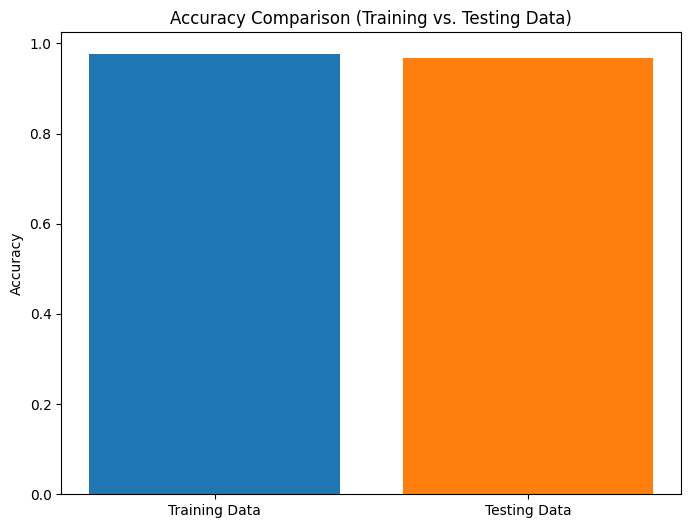

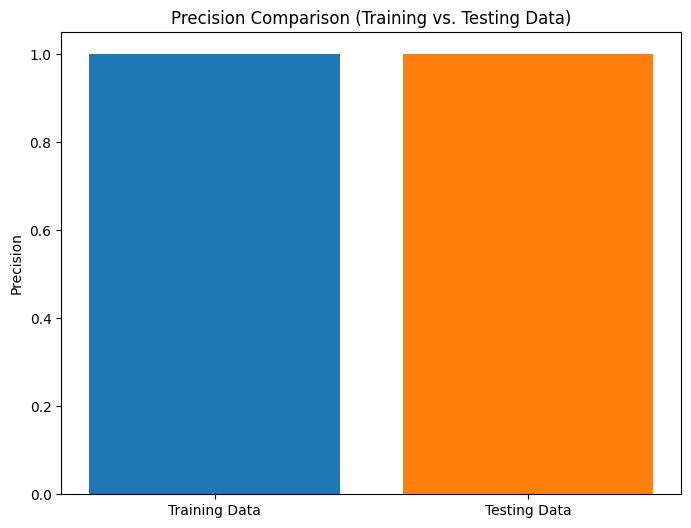

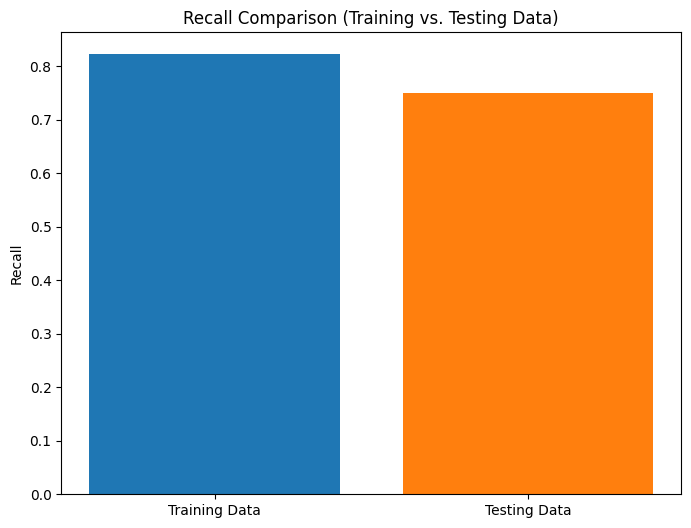

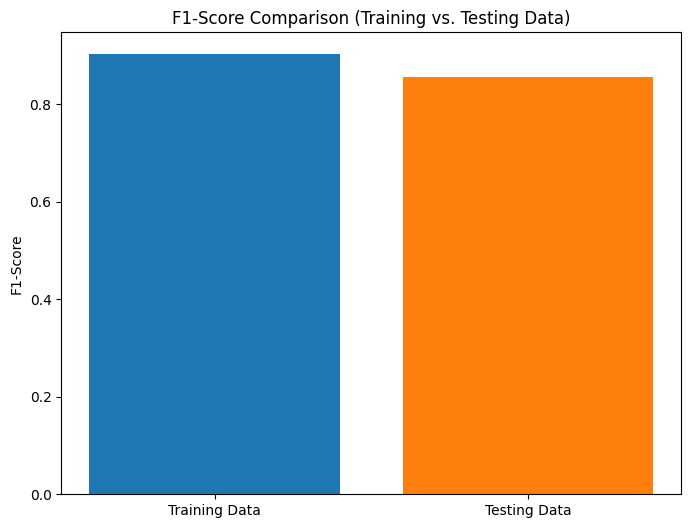

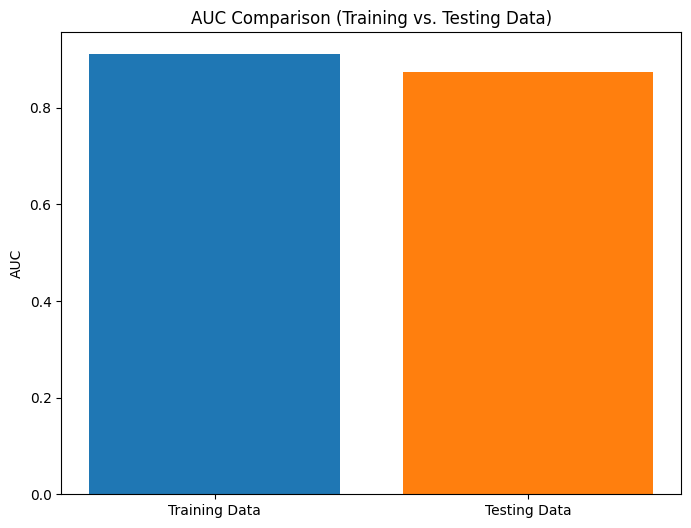

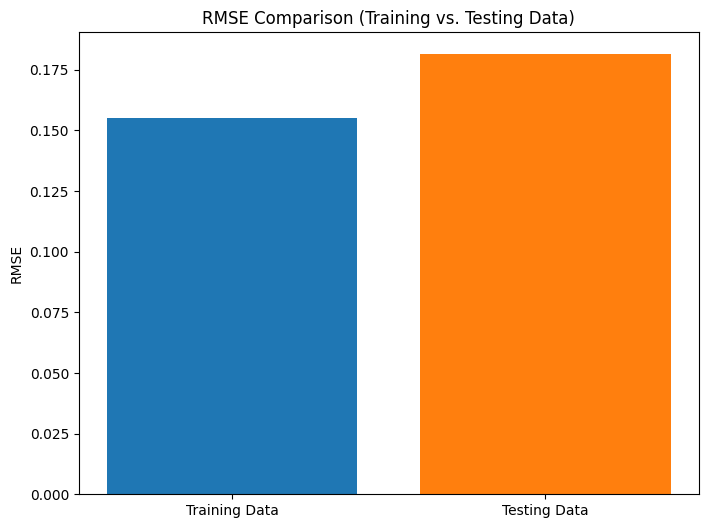

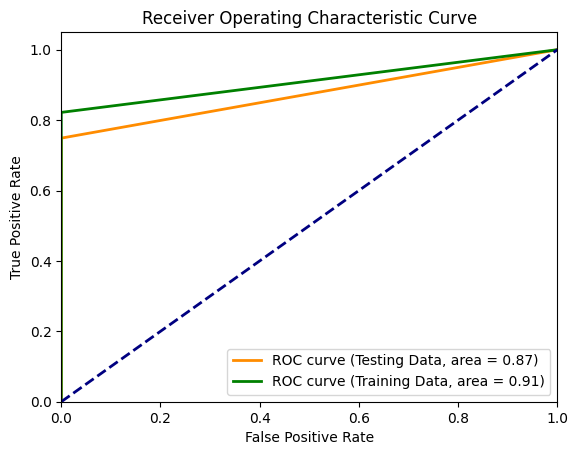

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, mean_squared_error
)
from hyperopt import fmin, tpe, hp, Trials
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load the dataset
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

# Split the data into 70% training and 30% testing
X = data['message']
y = data['label'].map({'ham': 0, 'spam': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Tokenize and vectorize the text using TF-IDF (fit only on training data)
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words=stopwords.words('english')
)

X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

# Define the objective function for Random Forest
def objective(params):
    model = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        random_state=42
    )

    model.fit(X_train, y_train)

    # Calculate evaluation metrics on the validation set
    predicted_labels = model.predict(X_test)

    # Calculate F1-score
    f1 = f1_score(y_test, predicted_labels)

    # Define the objective to maximize (e.g., F1-score)
    return -f1  # Minimize negative F1-score

# Set the Hyperparameter Search Space for Random Forest
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 1),
    'max_depth': hp.quniform('max_depth', 5, 30, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
}

# Initialize trials to keep track of optimization history
trials = Trials()

# Perform Bayesian optimization for Random Forest
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Extract the best hyperparameters for Random Forest
best_n_estimators = int(best['n_estimators'])
best_max_depth = int(best['max_depth'])
best_min_samples_split = int(best['min_samples_split'])
best_min_samples_leaf = int(best['min_samples_leaf'])

# Train the final Random Forest model with the best hyperparameters on the full training data
final_model = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42
)
final_model.fit(X_train, y_train)

# Evaluate the final Random Forest model on the testing data and calculate evaluation metrics
predicted_labels_test = final_model.predict(X_test)
accuracy_test = accuracy_score(y_test, predicted_labels_test)
precision_test = precision_score(y_test, predicted_labels_test)
recall_test = recall_score(y_test, predicted_labels_test)
f1_test = f1_score(y_test, predicted_labels_test)

# Calculate AUC, Confusion Matrix, and RMSE for testing data
roc_auc_test = roc_auc_score(y_test, predicted_labels_test)
cm_test = confusion_matrix(y_test, predicted_labels_test)
rmse_test = np.sqrt(mean_squared_error(y_test, predicted_labels_test))

# Calculate evaluation metrics for training data directly
predicted_labels_train = final_model.predict(X_train)
accuracy_train = accuracy_score(y_train, predicted_labels_train)
precision_train = precision_score(y_train, predicted_labels_train)
recall_train = recall_score(y_train, predicted_labels_train)
f1_train = f1_score(y_train, predicted_labels_train)

# Calculate AUC, Confusion Matrix, and RMSE for training data
roc_auc_train = roc_auc_score(y_train, predicted_labels_train)
cm_train = confusion_matrix(y_train, predicted_labels_train)
rmse_train = np.sqrt(mean_squared_error(y_train, predicted_labels_train))

# Define evaluation metrics for training and testing data
train_metrics = {
    'Accuracy': accuracy_train,
    'Precision': precision_train,
    'Recall': recall_train,
    'F1-Score': f1_train,
    'AUC': roc_auc_train,
    'RMSE': rmse_train
}

test_metrics = {
    'Accuracy': accuracy_test,
    'Precision': precision_test,
    'Recall': recall_test,
    'F1-Score': f1_test,
    'AUC': roc_auc_test,
    'RMSE': rmse_test
}

# Print the evaluation metrics for training data
print("Training Data Metrics:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1-Score:", f1_train)
print("AUC:", roc_auc_train)
print("RMSE:", rmse_train)
print("\n")

# Print the evaluation metrics for testing data
print("Testing Data Metrics:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-Score:", f1_test)
print("AUC:", roc_auc_test)
print("RMSE:", rmse_test)

# Plot each metric separately
for metric_name, values in train_metrics.items():
    plt.figure(figsize=(8, 6))
    plt.bar(['Training Data'], [train_metrics[metric_name]])
    plt.bar(['Testing Data'], [test_metrics[metric_name]])
    plt.title(f'{metric_name} Comparison (Training vs. Testing Data)')
    plt.ylabel(metric_name)
    plt.show()

# Plot the ROC curve for both training and testing data
fpr_test, tpr_test, _ = roc_curve(y_test, predicted_labels_test)
fpr_train, tpr_train, _ = roc_curve(y_train, predicted_labels_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (Testing Data, area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='green', lw=2, label='ROC curve (Training Data, area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()


CNN - WITH PREPROCESSING

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


53/53 [==============================] - 1s 21ms/step

53/53 [==============================] - 1s 22ms/step

53/53 [==============================] - 1s 17ms/step

53/53 [==============================] - 1s 14ms/step

53/53 [==============================] - 1s 17ms/step

53/53 [==============================] - 1s 25ms/step

53/53 [==============================] - 1s 13ms/step

53/53 [==============================] - 1s 11ms/step

53/53 [==============================] - 0s 6ms/step

53/53 [==============================] - 1s 14ms/step

53/53 [==============================] - 1s 15ms/step

53/53 [==============================] - 0s 6ms/step

53/53 [==============================] - 1s 9ms/step

53/53 [==============================] - 1s 15ms/step

53/53 [==============================] - 1s 22ms/step

53/53 [==============================] - 2s 29ms/step

53/53 [==============================] - 1s 19ms/step

53/53 [==============================] - 1s 24ms/step

53/53 [======

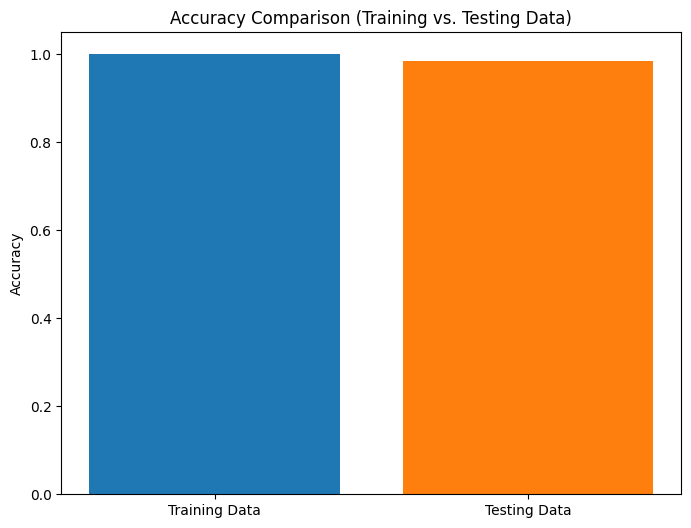

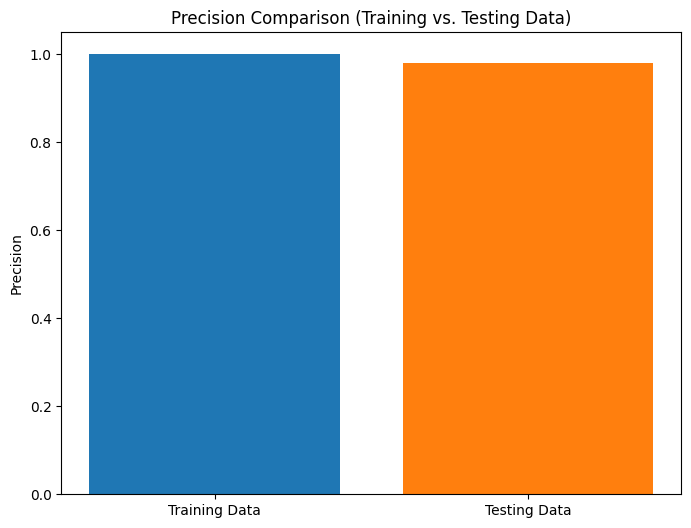

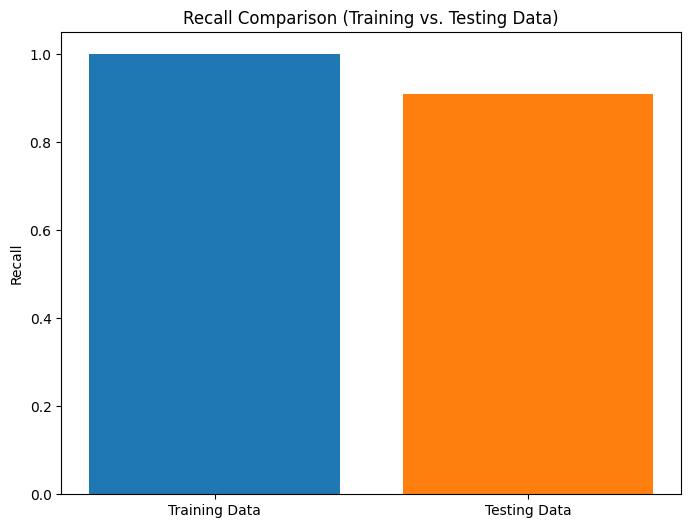

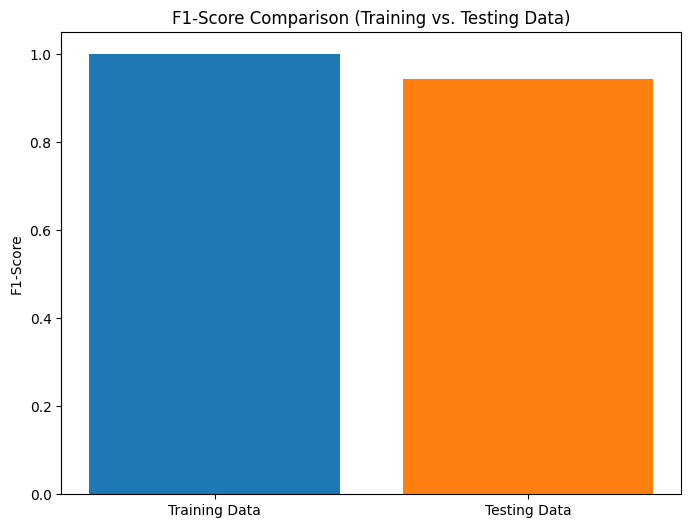

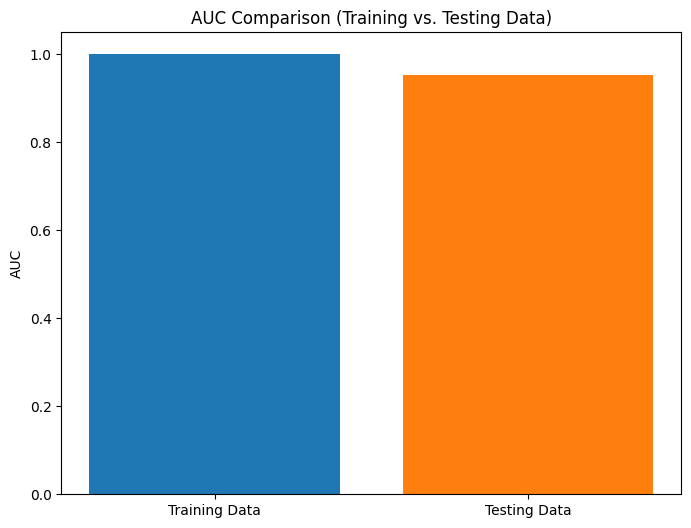

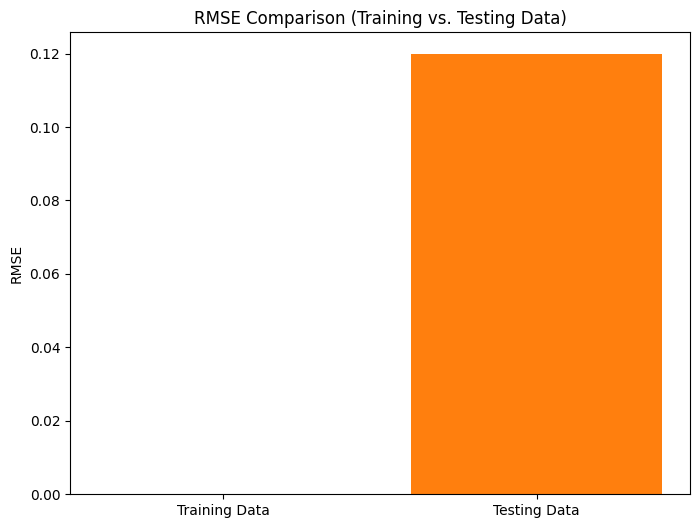

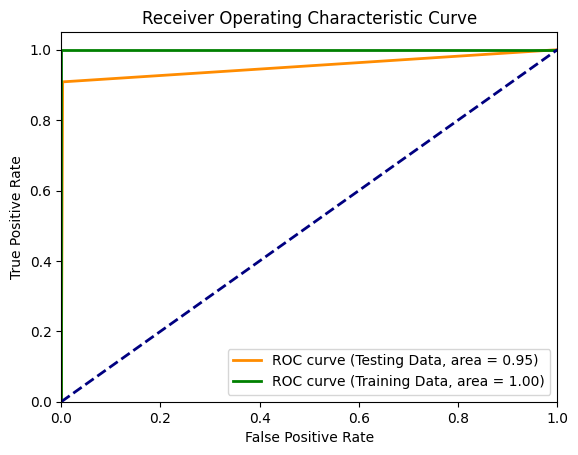

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from hyperopt import fmin, tpe, hp, Trials
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import nltk
nltk.download('stopwords')



# Load the dataset
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

# Preprocessing
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

# Text preprocessing
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Remove special characters and numeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()

    # Tokenization
    words = text.split()

    # Remove stop words and apply stemming
    words = [stemmer.stem(word) for word in words if word not in stop_words]

    return ' '.join(words)

data['message'] = data['message'].apply(preprocess_text)

# Tokenization and Vectorization
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(data['message'])
X = tokenizer.texts_to_sequences(data['message'])
X = pad_sequences(X)

y = data['label']

# Split data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the objective function with rounded hyperparameter values
def objective(params):
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=int(params['embedding_dim']), input_length=X_train.shape[1]))
    model.add(Conv1D(filters=int(params['num_filters']), kernel_size=int(params['filter_size']), activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=int(params['dense_units']), activation='relu'))
    model.add(Dropout(rate=params['dropout']))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']), verbose=0)

    # Evaluate the model
    y_pred_test = (model.predict(X_test) > 0.5).astype(int)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # Define the objective to maximize (e.g., maximize accuracy)
    return -accuracy_test  # Minimize negative accuracy (maximize accuracy)

space = {
    'embedding_dim': hp.quniform('embedding_dim', 50, 300, 10),
    'num_filters': hp.quniform('num_filters', 32, 128, 1),
    'filter_size': hp.quniform('filter_size', 3, 10, 1),
    'dense_units': hp.quniform('dense_units', 32, 256, 1),
    'dropout': hp.uniform('dropout', 0.2, 0.5),
    'epochs': hp.quniform('epochs', 5, 30, 1),
    'batch_size': hp.quniform('batch_size', 16, 128, 16),
}
trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

best_embedding_dim = int(best['embedding_dim'])
best_num_filters = int(best['num_filters'])
best_filter_size = int(best['filter_size'])
best_dense_units = int(best['dense_units'])
best_dropout = best['dropout']
best_epochs = int(best['epochs'])
best_batch_size = int(best['batch_size'])
final_model = Sequential()
final_model.add(Embedding(input_dim=max_features, output_dim=best_embedding_dim, input_length=X_train.shape[1]))
final_model.add(Conv1D(filters=best_num_filters, kernel_size=best_filter_size, activation='relu'))
final_model.add(GlobalMaxPooling1D())
final_model.add(Dense(units=best_dense_units, activation='relu'))
final_model.add(Dropout(rate=best_dropout))
final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
final_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size)

# Evaluate the final model
y_pred_test = (final_model.predict(X_test) > 0.5).astype(int)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

# Calculate AUC, Confusion Matrix, and RMSE
roc_auc_test = roc_auc_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("Testing Data Metrics:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-Score:", f1_test)
print("AUC:", roc_auc_test)
print("Confusion Matrix:\n", cm_test)
print("RMSE:", rmse_test)

# Separate graphs for training and testing evaluation metrics
def plot_metrics(train_metrics, test_metrics, metric_name):
    plt.figure(figsize=(8, 6))
    plt.bar(['Training Data'], [train_metrics[metric_name]])
    plt.bar(['Testing Data'], [test_metrics[metric_name]])
    plt.title(f'{metric_name} Comparison (Training vs. Testing Data)')
    plt.ylabel(metric_name)
    plt.show()

# Calculate evaluation metrics for training data directly
y_pred_train = (final_model.predict(X_train) > 0.5).astype(int)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

# Calculate AUC, Confusion Matrix, and RMSE for training data
roc_auc_train = roc_auc_score(y_train, y_pred_train)
cm_train = confusion_matrix(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Define evaluation metrics for training and testing data
train_metrics = {
    'Accuracy': accuracy_train,
    'Precision': precision_train,
    'Recall': recall_train,
    'F1-Score': f1_train,
    'AUC': roc_auc_train,
    'RMSE': rmse_train
}

test_metrics = {
    'Accuracy': accuracy_test,
    'Precision': precision_test,
    'Recall': recall_test,
    'F1-Score': f1_test,
    'AUC': roc_auc_test,
    'RMSE': rmse_test
}

# Plot evaluation metrics separately
for metric_name in train_metrics.keys():
    plot_metrics(train_metrics, test_metrics, metric_name)

# Plot the ROC curve for both training and testing data
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (Testing Data, area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='green', lw=2, label='ROC curve (Training Data, area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()


CNN - WITHOUT PREPROCESSING

122/122 [==============================] - 8s 63ms/step

53/53 [==============================] - 4s 76ms/step

122/122 [==============================] - 2s 13ms/step

53/53 [==============================] - 1s 25ms/step

122/122 [==============================] - 3s 21ms/step

53/53 [==============================] - 2s 31ms/step

122/122 [==============================] - 3s 21ms/step

53/53 [==============================] - 2s 44ms/step

122/122 [==============================] - 3s 28ms/step

53/53 [==============================] - 3s 59ms/step

122/122 [==============================] - 2s 19ms/step

53/53 [==============================] - 1s 26ms/step

122/122 [==============================] - 4s 36ms/step

53/53 [==============================] - 4s 66ms/step

122/122 [==============================] - 3s 20ms/step

53/53 [==============================] - 2s 29ms/step

122/122 [==============================] - 2s 17ms/step

53/53 [==============================] - 1s 25m

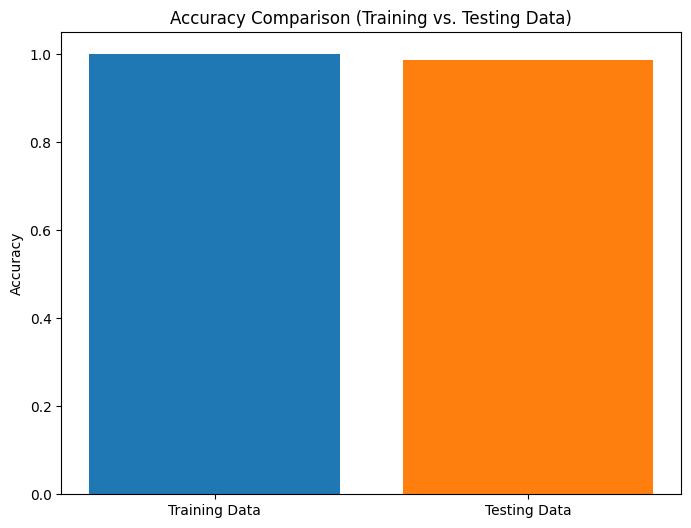

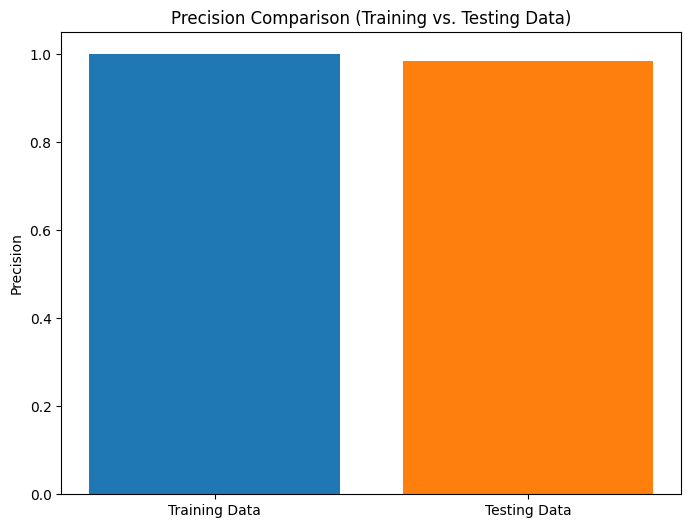

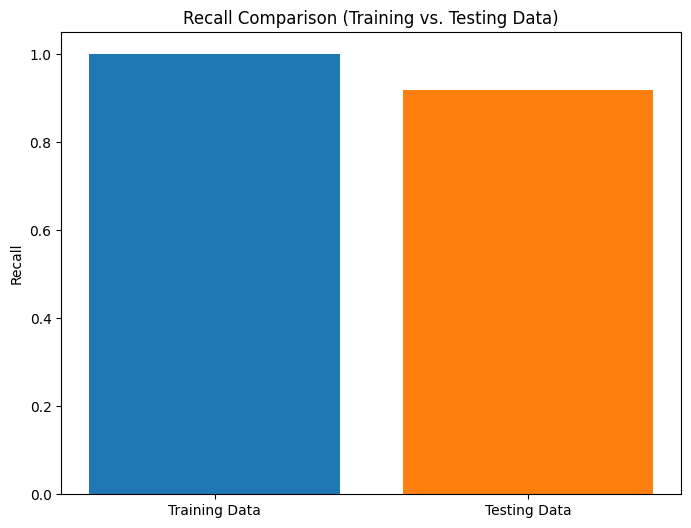

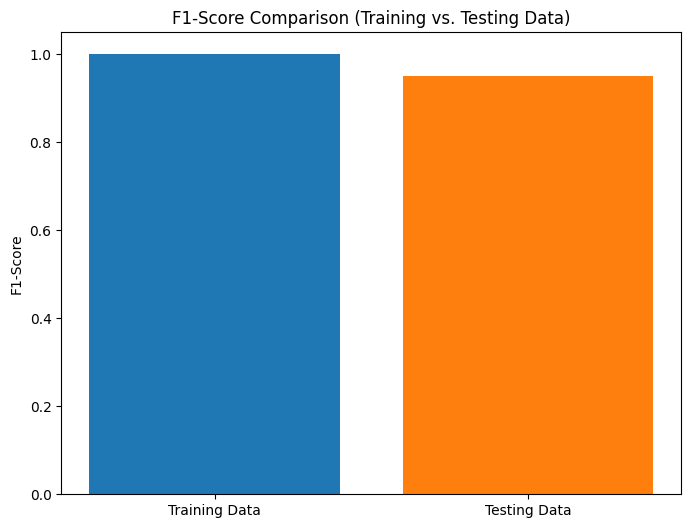

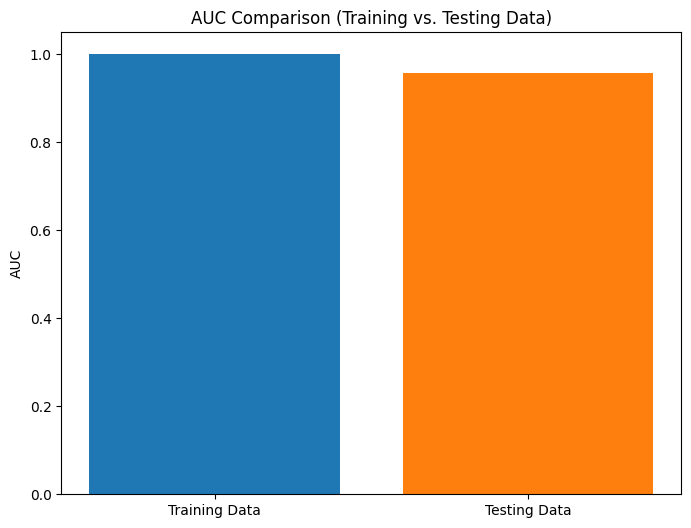

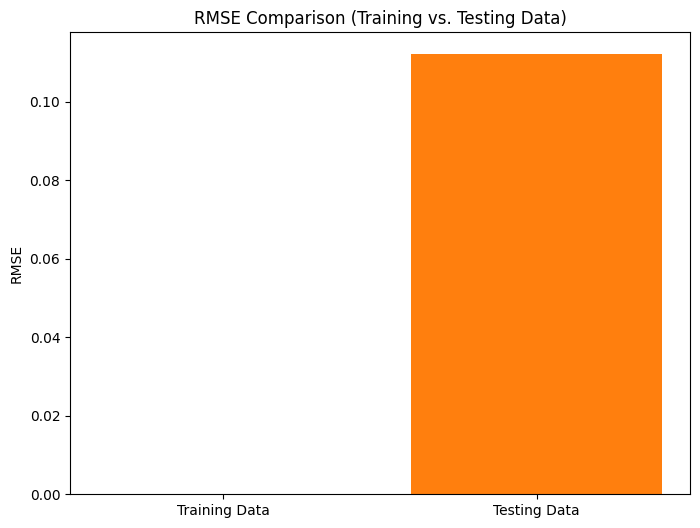

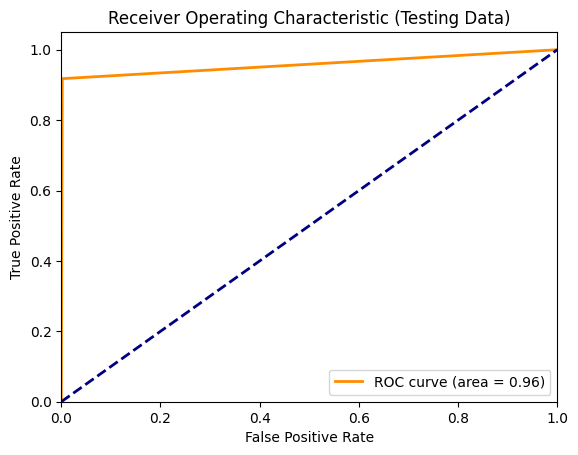

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from hyperopt import fmin, tpe, hp, Trials
import re
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load the dataset
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

# Encoding labels
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['message'], data['label'], test_size=0.3, random_state=42)

# Tokenization and Vectorization
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test)

# Define the objective function with hyperparameters
def objective(params):
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=int(params['embedding_dim']), input_length=X_train.shape[1]))
    model.add(Conv1D(filters=int(params['num_filters']), kernel_size=int(params['filter_size']), activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=int(params['dense_units']), activation='relu'))
    model.add(Dropout(rate=params['dropout']))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']), verbose=0)

    # Evaluate the model on training data
    y_pred_train = (model.predict(X_train) > 0.5).astype(int)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    # Evaluate the model on testing data
    y_pred_test = (model.predict(X_test) > 0.5).astype(int)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # Define the objective to maximize (e.g., maximize accuracy on testing data)
    return -accuracy_test  # Minimize negative accuracy on testing data (maximize testing accuracy)

# Hyperparameter search space
space = {
    'embedding_dim': hp.quniform('embedding_dim', 50, 300, 10),
    'num_filters': hp.quniform('num_filters', 32, 128, 1),
    'filter_size': hp.quniform('filter_size', 3, 10, 1),
    'dense_units': hp.quniform('dense_units', 32, 256, 1),
    'dropout': hp.uniform('dropout', 0.2, 0.5),
    'epochs': hp.quniform('epochs', 5, 30, 1),
    'batch_size': hp.quniform('batch_size', 16, 128, 16),
}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

best_embedding_dim = int(best['embedding_dim'])
best_num_filters = int(best['num_filters'])
best_filter_size = int(best['filter_size'])
best_dense_units = int(best['dense_units'])
best_dropout = best['dropout']
best_epochs = int(best['epochs'])
best_batch_size = int(best['batch_size'])

# Build the final model with the best hyperparameters
final_model = Sequential()
final_model.add(Embedding(input_dim=max_features, output_dim=best_embedding_dim, input_length=X_train.shape[1]))
final_model.add(Conv1D(filters=best_num_filters, kernel_size=best_filter_size, activation='relu'))
final_model.add(GlobalMaxPooling1D())
final_model.add(Dense(units=best_dense_units, activation='relu'))
final_model.add(Dropout(rate=best_dropout))
final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
final_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size)

# Evaluate the final model on training and testing data
y_pred_train = (final_model.predict(X_train) > 0.5).astype(int)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
roc_auc_train = roc_auc_score(y_train, y_pred_train)
cm_train = confusion_matrix(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

y_pred_test = (final_model.predict(X_test) > 0.5).astype(int)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print evaluation metrics for training and testing data
print("Training Data Metrics:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1-Score:", f1_train)
print("AUC:", roc_auc_train)
print("Confusion Matrix:\n", cm_train)
print("RMSE:", rmse_train)
print("\n")

print("Testing Data Metrics:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-Score:", f1_test)
print("AUC:", roc_auc_test)
print("Confusion Matrix:\n", cm_test)
print("RMSE:", rmse_test)

# Separate graphs for training and testing evaluation metrics
train_metrics = {
    'Accuracy': accuracy_train,
    'Precision': precision_train,
    'Recall': recall_train,
    'F1-Score': f1_train,
    'AUC': roc_auc_train,
    'RMSE': rmse_train
}

test_metrics = {
    'Accuracy': accuracy_test,
    'Precision': precision_test,
    'Recall': recall_test,
    'F1-Score': f1_test,
    'AUC': roc_auc_test,
    'RMSE': rmse_test
}

# Plot each metric separately
for metric_name, values in train_metrics.items():
    plt.figure(figsize=(8, 6))
    plt.bar(['Training Data'], [train_metrics[metric_name]])
    plt.bar(['Testing Data'], [test_metrics[metric_name]])
    plt.title(f'{metric_name} Comparison (Training vs. Testing Data)')
    plt.ylabel(metric_name)
    plt.show()

# ROC curve for testing data
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Testing Data)')
plt.legend(loc='lower right')
plt.show()


DECISION TREE - WITH PREPROCESSING

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100%|██████████| 50/50 [00:22<00:00,  2.27trial/s, best loss: -0.8477611940298507]
Testing Data Metrics:
Accuracy: 0.9593301435406698
Precision: 0.9265536723163842
Recall: 0.7488584474885844
F1-Score: 0.8282828282828282
AUC: 0.8645928593651303
RMSE: 0.20166768818858946
Confusion Matrix:
[[1440   13]
 [  55  164]]

Training Data Metrics:
Accuracy: 0.985897435897436
Precision: 0.9958071278825996
Recall: 0.8996212121212122
F1-Score: 0.9452736318407962
AUC: 0.956737919677199
RMSE: 0.11875421719907088
Confusion Matrix (Training Data):
[[3370    2]
 [  53  475]]


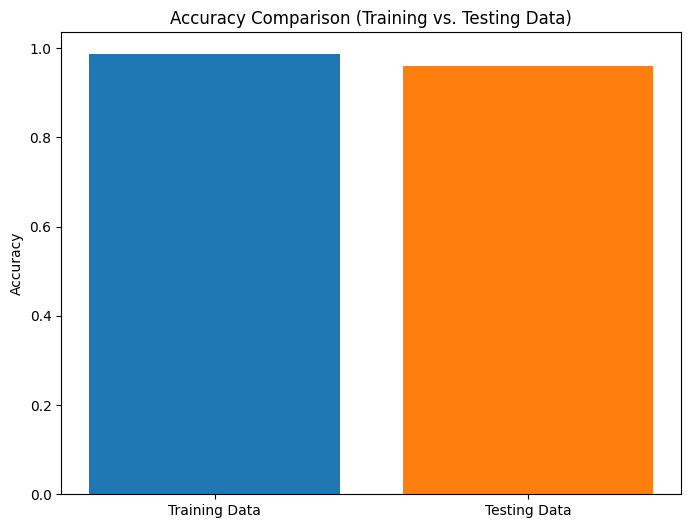

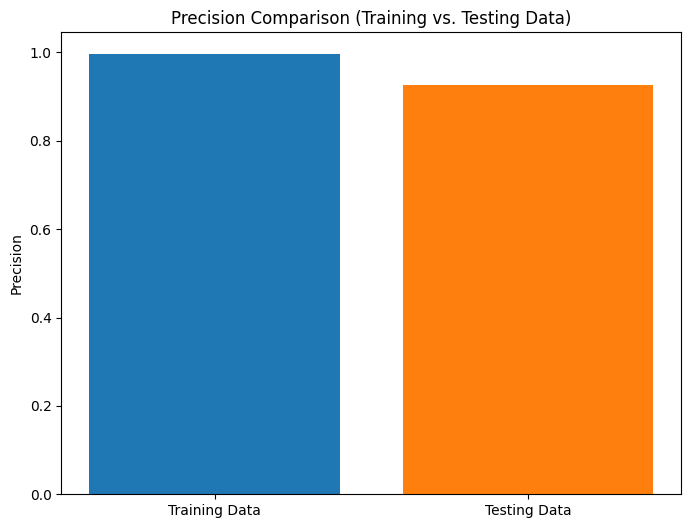

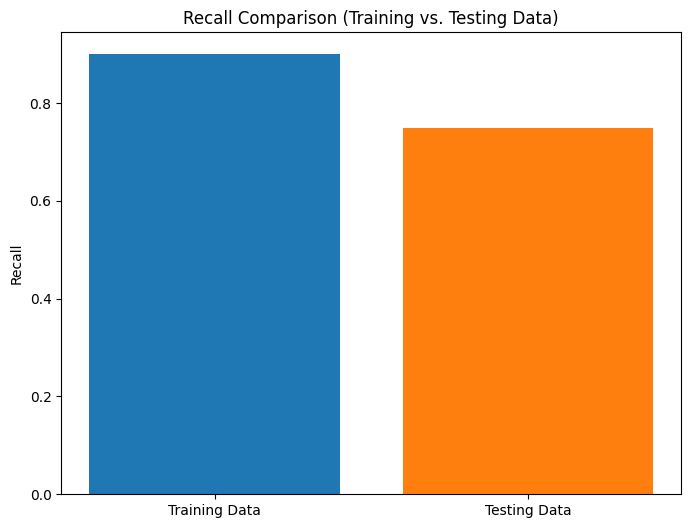

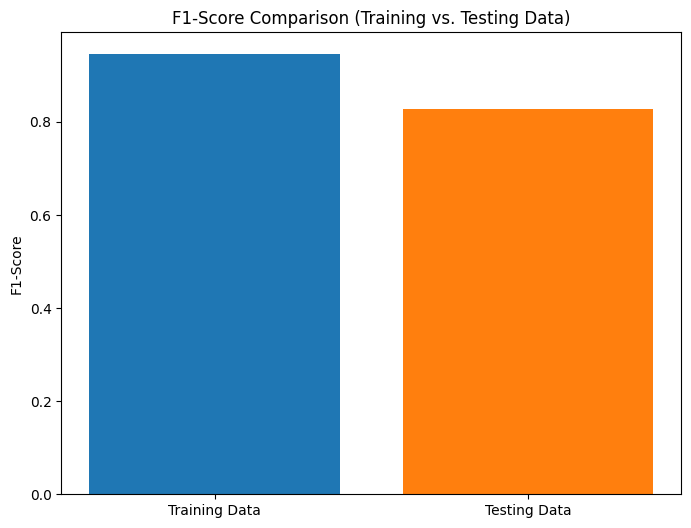

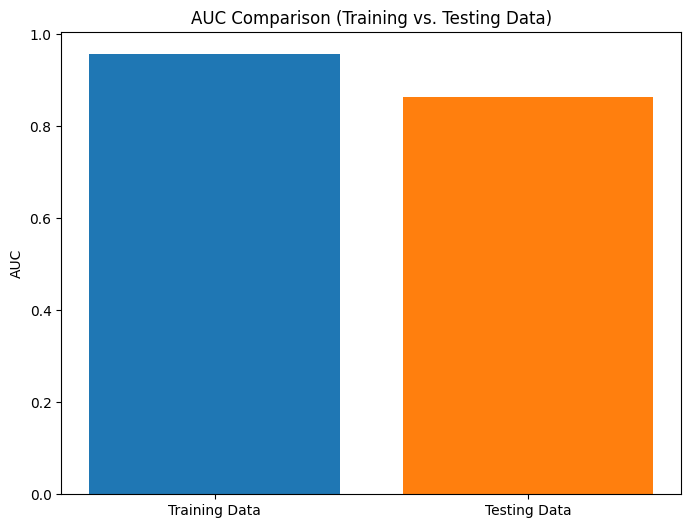

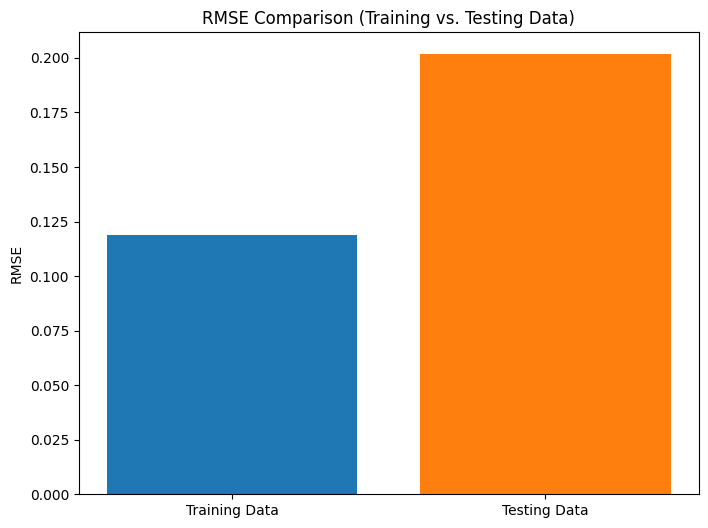

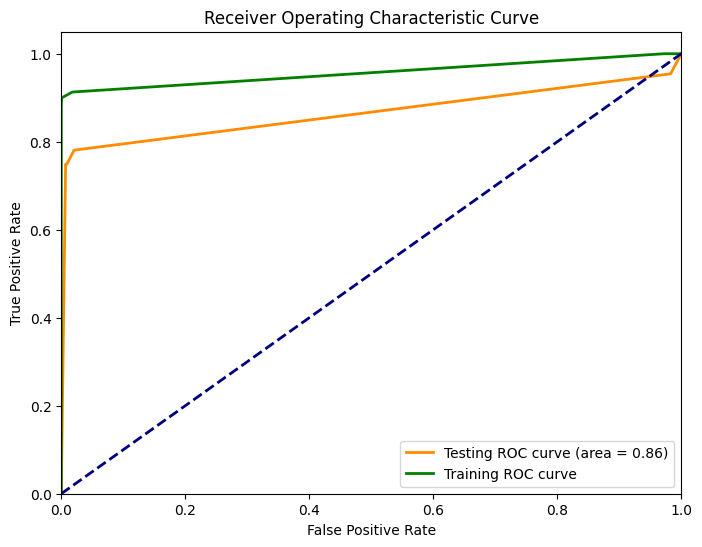

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, mean_squared_error, auc
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')

# Step 1: Load the dataset
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

# Step 2: Data Preprocessing
# Remove special characters and numbers, perform stemming, and punctuation removal
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
data['message'] = data['message'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
data['message'] = data['message'].apply(lambda x: re.sub(r'\d+', '', x))
data['message'] = data['message'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
data['message'] = data['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Step 3: Split the data into 70% training and 30% testing
X = data['message']
y = data['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Tokenize and vectorize the text using TF-IDF (fit only on training data)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

# Step 4: Define the objective function
def objective(params):
    model = DecisionTreeClassifier(
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        random_state=42
    )

    # Use cross_val_predict to obtain predicted labels for evaluation
    predicted_labels = cross_val_predict(model, X_train, y_train, cv=5)

    # Calculate evaluation metrics
    f1 = f1_score(y_train, predicted_labels)

    # Define the objective to maximize (e.g., F1-score)
    return -f1  # Minimize negative F1-score

# Step 5: Set the Hyperparameter Search Space
space = {
    'max_depth': hp.quniform('max_depth', 5, 30, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
}

# Step 6: Initialize trials to keep track of optimization history
trials = Trials()

# Step 7: Perform Bayesian optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Step 8: Extract the best hyperparameters
best_max_depth = int(best['max_depth'])
best_min_samples_split = int(best['min_samples_split'])
best_min_samples_leaf = int(best['min_samples_leaf'])

# Step 9: Train the final Decision Tree model with the best hyperparameters on the full training data
final_model = DecisionTreeClassifier(
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42
)
final_model.fit(X_train, y_train)

# Step 10: Evaluate the final model and calculate evaluation metrics on the testing data
predicted_labels = final_model.predict(X_test)
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

# Calculate AUC (this assumes binary classification)
probs = final_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)

# Calculate RMSE (this assumes a regression task, if it's not, please clarify)
rmse = np.sqrt(mean_squared_error(y_test, predicted_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Step 11: Print the evaluation metrics
print("Testing Data Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)
print("RMSE:", rmse)
print("Confusion Matrix:")
print(conf_matrix)

# Step 12: Plot evaluation metrics for training and testing data
def plot_metrics(train_metrics, test_metrics, metric_name):
    plt.figure(figsize=(8, 6))
    plt.bar(['Training Data'], [train_metrics[metric_name]])
    plt.bar(['Testing Data'], [test_metrics[metric_name]])
    plt.title(f'{metric_name} Comparison (Training vs. Testing Data)')
    plt.ylabel(metric_name)
    plt.show()

# Calculate evaluation metrics for training data
predicted_labels_train = final_model.predict(X_train)
accuracy_train = accuracy_score(y_train, predicted_labels_train)
precision_train = precision_score(y_train, predicted_labels_train)
recall_train = recall_score(y_train, predicted_labels_train)
f1_train = f1_score(y_train, predicted_labels_train)

# Calculate AUC (training data)
probs_train = final_model.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, probs_train)

# Calculate RMSE (training data)
rmse_train = np.sqrt(mean_squared_error(y_train, predicted_labels_train))

# Confusion Matrix (training data)
conf_matrix_train = confusion_matrix(y_train, predicted_labels_train)

# Step 13: Print the evaluation metrics for training data
print("\nTraining Data Metrics:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1-Score:", f1_train)
print("AUC:", auc_train)
print("RMSE:", rmse_train)
print("Confusion Matrix (Training Data):")
print(conf_matrix_train)

# Step 14: Plot evaluation metrics for training and testing data
plot_metrics(
    {'Accuracy': accuracy_train, 'Precision': precision_train, 'Recall': recall_train, 'F1-Score': f1_train, 'AUC': auc_train, 'RMSE': rmse_train},
    {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc, 'RMSE': rmse},
    'Accuracy'
)
plot_metrics(
    {'Accuracy': accuracy_train, 'Precision': precision_train, 'Recall': recall_train, 'F1-Score': f1_train, 'AUC': auc_train, 'RMSE': rmse_train},
    {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc, 'RMSE': rmse},
    'Precision'
)
plot_metrics(
    {'Accuracy': accuracy_train, 'Precision': precision_train, 'Recall': recall_train, 'F1-Score': f1_train, 'AUC': auc_train, 'RMSE': rmse_train},
    {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc, 'RMSE': rmse},
    'Recall'
)
plot_metrics(
    {'Accuracy': accuracy_train, 'Precision': precision_train, 'Recall': recall_train, 'F1-Score': f1_train, 'AUC': auc_train, 'RMSE': rmse_train},
    {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc, 'RMSE': rmse},
    'F1-Score'
)
plot_metrics(
    {'Accuracy': accuracy_train, 'Precision': precision_train, 'Recall': recall_train, 'F1-Score': f1_train, 'AUC': auc_train, 'RMSE': rmse_train},
    {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc, 'RMSE': rmse},
    'AUC'
)
plot_metrics(
    {'Accuracy': accuracy_train, 'Precision': precision_train, 'Recall': recall_train, 'F1-Score': f1_train, 'AUC': auc_train, 'RMSE': rmse_train},
    {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc, 'RMSE': rmse},
    'RMSE'
)

# Step 12: Plot ROC Curve for both training and testing data
probs_train = final_model.predict_proba(X_train)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Testing ROC curve (area = %0.2f)' % auc)
plt.plot(fpr_train, tpr_train, color='green', lw=2, label='Training ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()








DECISION TREE -WITHOUT PREPROCESSING

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100%|██████████| 50/50 [00:20<00:00,  2.47trial/s, best loss: -0.8656126482213439]
Testing Data Metrics:
Accuracy: 0.97188995215311
Precision: 0.9343434343434344
Recall: 0.8447488584474886
F1-Score: 0.8872901678657075
AUC: 0.9103995198094323
RMSE: 0.16766051367835527
Confusion Matrix:
[[1440   13]
 [  34  185]]

Training Data Metrics:
Accuracy: 0.9917948717948718
Precision: 1.0
Recall: 0.9393939393939394
F1-Score: 0.96875
AUC: 0.9705147561019447
RMSE: 0.09058216273156766
Confusion Matrix (Training Data):
[[3372    0]
 [  32  496]]


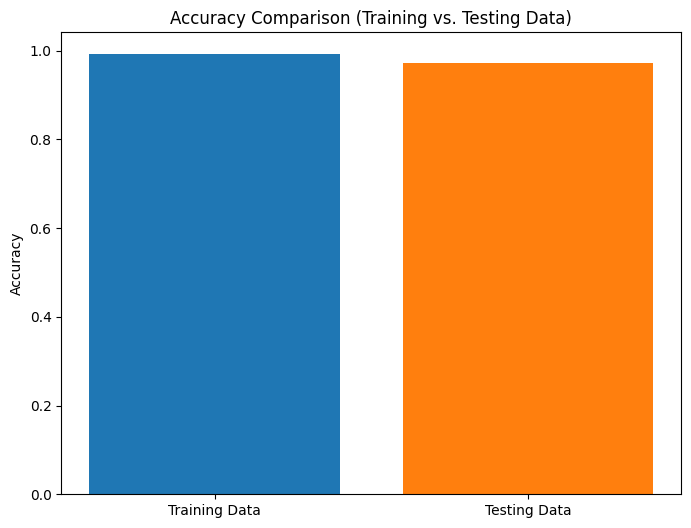

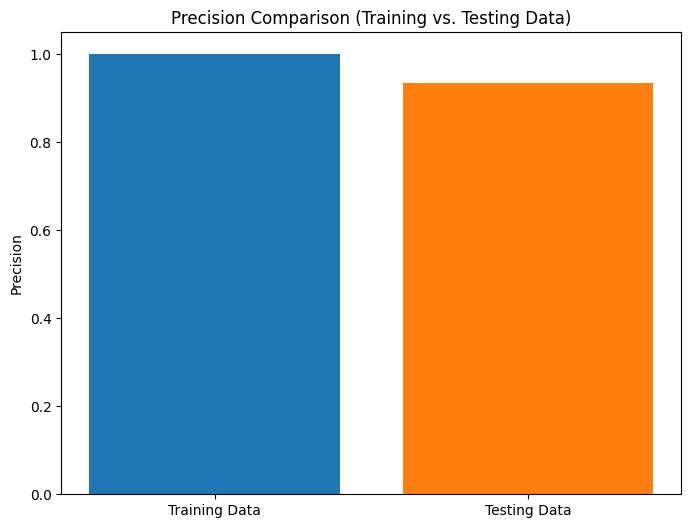

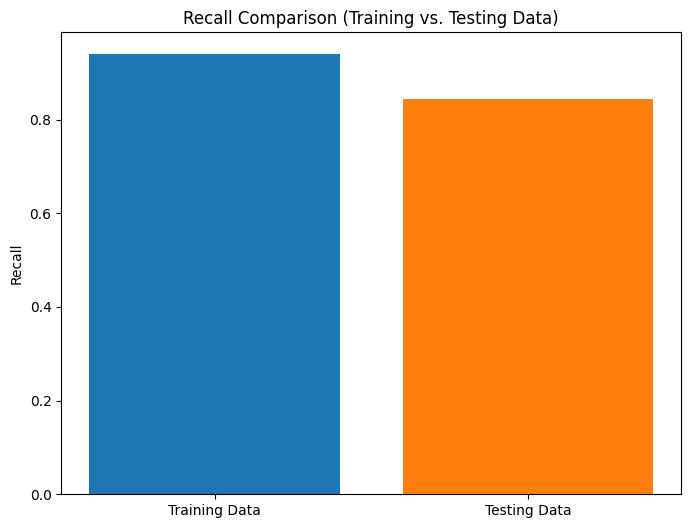

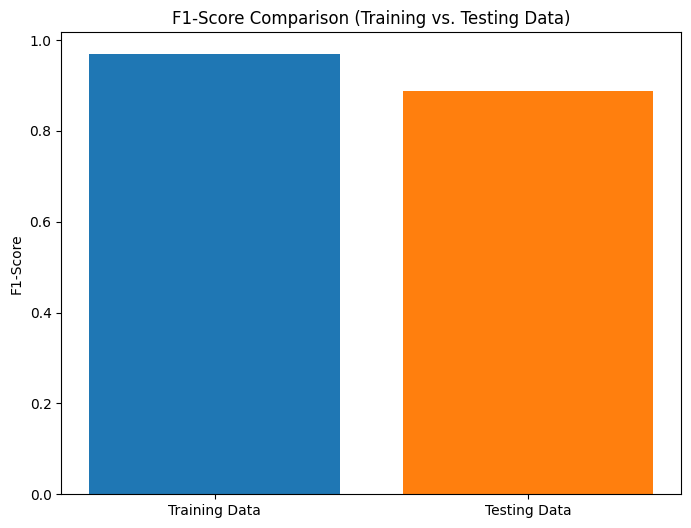

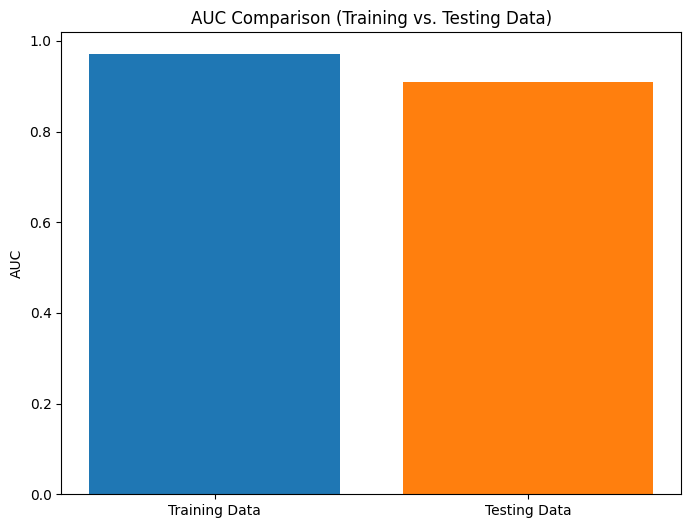

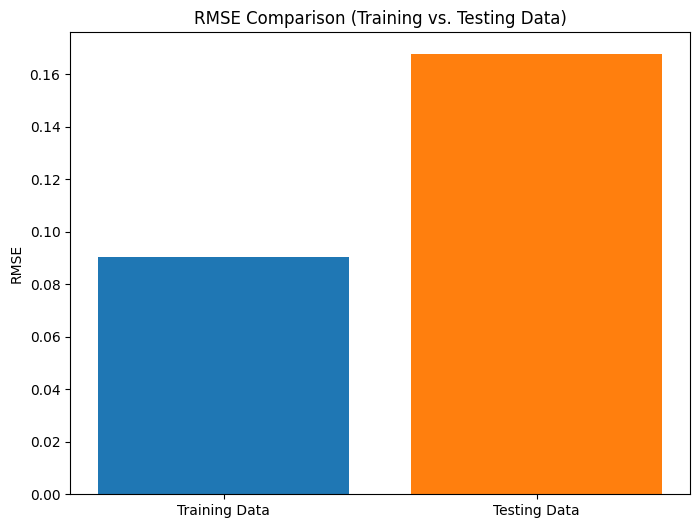

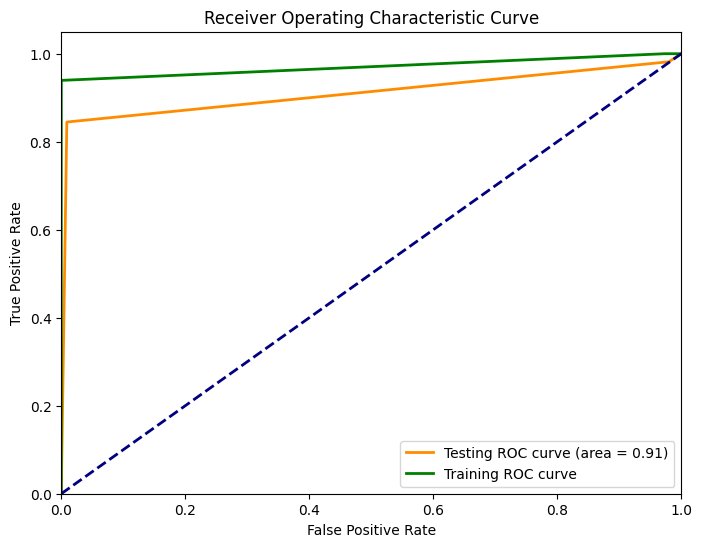

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, mean_squared_error, auc
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')

# Step 1: Load the dataset
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

# Step 3: Split the data into 70% training and 30% testing
X = data['message']
y = data['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Tokenize and vectorize the text using TF-IDF (fit only on training data)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

# Step 4: Define the objective function
def objective(params):
    model = DecisionTreeClassifier(
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        random_state=42
    )

    # Use cross_val_predict to obtain predicted labels for evaluation
    predicted_labels = cross_val_predict(model, X_train, y_train, cv=5)

    # Calculate evaluation metrics
    f1 = f1_score(y_train, predicted_labels)

    # Define the objective to maximize (e.g., F1-score)
    return -f1  # Minimize negative F1-score

# Step 5: Set the Hyperparameter Search Space
space = {
    'max_depth': hp.quniform('max_depth', 5, 30, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
}

# Step 6: Initialize trials to keep track of optimization history
trials = Trials()

# Step 7: Perform Bayesian optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Step 8: Extract the best hyperparameters
best_max_depth = int(best['max_depth'])
best_min_samples_split = int(best['min_samples_split'])
best_min_samples_leaf = int(best['min_samples_leaf'])

# Step 9: Train the final Decision Tree model with the best hyperparameters on the full training data
final_model = DecisionTreeClassifier(
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42
)
final_model.fit(X_train, y_train)

# Step 10: Evaluate the final model and calculate evaluation metrics on the testing data
predicted_labels = final_model.predict(X_test)
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

# Calculate AUC (this assumes binary classification)
probs = final_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)

# Calculate RMSE (this assumes a regression task, if it's not, please clarify)
rmse = np.sqrt(mean_squared_error(y_test, predicted_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Step 11: Print the evaluation metrics
print("Testing Data Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)
print("RMSE:", rmse)
print("Confusion Matrix:")
print(conf_matrix)

# Step 12: Plot evaluation metrics for training and testing data
def plot_metrics(train_metrics, test_metrics, metric_name):
    plt.figure(figsize=(8, 6))
    plt.bar(['Training Data'], [train_metrics[metric_name]])
    plt.bar(['Testing Data'], [test_metrics[metric_name]])
    plt.title(f'{metric_name} Comparison (Training vs. Testing Data)')
    plt.ylabel(metric_name)
    plt.show()

# Calculate evaluation metrics for training data
predicted_labels_train = final_model.predict(X_train)
accuracy_train = accuracy_score(y_train, predicted_labels_train)
precision_train = precision_score(y_train, predicted_labels_train)
recall_train = recall_score(y_train, predicted_labels_train)
f1_train = f1_score(y_train, predicted_labels_train)

# Calculate AUC (training data)
probs_train = final_model.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, probs_train)

# Calculate RMSE (training data)
rmse_train = np.sqrt(mean_squared_error(y_train, predicted_labels_train))

# Confusion Matrix (training data)
conf_matrix_train = confusion_matrix(y_train, predicted_labels_train)

# Step 13: Print the evaluation metrics for training data
print("\nTraining Data Metrics:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1-Score:", f1_train)
print("AUC:", auc_train)
print("RMSE:", rmse_train)
print("Confusion Matrix (Training Data):")
print(conf_matrix_train)

# Step 14: Plot evaluation metrics for training and testing data
plot_metrics(
    {'Accuracy': accuracy_train, 'Precision': precision_train, 'Recall': recall_train, 'F1-Score': f1_train, 'AUC': auc_train, 'RMSE': rmse_train},
    {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc, 'RMSE': rmse},
    'Accuracy'
)
plot_metrics(
    {'Accuracy': accuracy_train, 'Precision': precision_train, 'Recall': recall_train, 'F1-Score': f1_train, 'AUC': auc_train, 'RMSE': rmse_train},
    {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc, 'RMSE': rmse},
    'Precision'
)
plot_metrics(
    {'Accuracy': accuracy_train, 'Precision': precision_train, 'Recall': recall_train, 'F1-Score': f1_train, 'AUC': auc_train, 'RMSE': rmse_train},
    {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc, 'RMSE': rmse},
    'Recall'
)
plot_metrics(
    {'Accuracy': accuracy_train, 'Precision': precision_train, 'Recall': recall_train, 'F1-Score': f1_train, 'AUC': auc_train, 'RMSE': rmse_train},
    {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc, 'RMSE': rmse},
    'F1-Score'
)
plot_metrics(
    {'Accuracy': accuracy_train, 'Precision': precision_train, 'Recall': recall_train, 'F1-Score': f1_train, 'AUC': auc_train, 'RMSE': rmse_train},
    {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc, 'RMSE': rmse},
    'AUC'
)
plot_metrics(
    {'Accuracy': accuracy_train, 'Precision': precision_train, 'Recall': recall_train, 'F1-Score': f1_train, 'AUC': auc_train, 'RMSE': rmse_train},
    {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc, 'RMSE': rmse},
    'RMSE'
)

# Step 12: Plot ROC Curve for both training and testing data
probs_train = final_model.predict_proba(X_train)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Testing ROC curve (area = %0.2f)' % auc)
plt.plot(fpr_train, tpr_train, color='green', lw=2, label='Training ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()





For 100% dataset
(without applying bayesian optimization)

NAIVE BAYES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, mean_squared_error, roc_curve, auc
)
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import matplotlib.pyplot as plt

# Step 1: Load the dataset from Kaggle
data = pd.read_csv('/content/spam.csv', encoding='latin-1')


# Step 2: Data Preprocessing
# Remove special characters, numeric characters, and perform stemming
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)           # Remove numeric characters
    text = ' '.join([stemmer.stem(word) for word in text.split()])  # Stemming
    return ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords

data['v2'] = data['v2'].apply(preprocess_text)


# Step 3: Split the data into 70% training and 30% testing
X = data['v2']
y = data['v1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Step 4: Tokenize and vectorize the text using TF-IDF (fit only on training data)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

# Step 5: Train the Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Step 6: Predict labels on the testing data
predicted_labels = model.predict(X_test)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)

# Calculate precision
precision = precision_score(y_test, predicted_labels, pos_label='spam')

# Calculate recall
recall = recall_score(y_test, predicted_labels, pos_label='spam')

# Calculate F1-score
f1 = f1_score(y_test, predicted_labels, pos_label='spam')

# Calculate AUC
probs = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)
print("Confusion Matrix:")
print(conf_matrix)




Accuracy: 0.958732057416268
Precision: 1.0
Recall: 0.684931506849315
F1-Score: 0.8130081300813007
AUC: 0.9739446335247182
Confusion Matrix:
[[1453    0]
 [  69  150]]


RANDOM FOREST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, confusion_matrix
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Step 1: Load the dataset
data = pd.read_csv('spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

# Step 2: Data Preprocessing
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove special characters and numeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenize and perform stemming
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Remove punctuation and convert to lowercase
    cleaned_text = ' '.join(stemmed_tokens)

    return cleaned_text

data['message'] = data['message'].apply(preprocess_text)

# Step 3: Split the data into training and testing sets
X = data['message']
y = data['label'].map({'ham': 0, 'spam': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Step 4: Vectorize text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

# Step 5: Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Step 6: Evaluate the Model
predicted_labels = rf_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
probs = rf_classifier.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
rmse = np.sqrt(mean_squared_error(y_test, predicted_labels))
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)
print("RMSE:", rmse)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.97188995215311
Precision: 0.9942528735632183
Recall: 0.7899543378995434
F1-Score: 0.8804071246819337
AUC: 0.979522763484147
RMSE: 0.16766051367835527
Confusion Matrix:
[[1452    1]
 [  46  173]]


DECISION TREE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, mean_squared_error, confusion_matrix
)
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Step 1: Load the dataset
data = pd.read_csv('spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

# Step 2: Data Preprocessing
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove special characters and numeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenize and perform stemming
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Remove punctuation and convert to lowercase
    cleaned_text = ' '.join(stemmed_tokens)

    return cleaned_text

data['message'] = data['message'].apply(preprocess_text)

# Step 3: Split the data into training and testing sets
X = data['message']
y = data['label'].map({'ham': 0, 'spam': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Step 4: Vectorize text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

# Step 5: Train Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Step 6: Evaluate the Model
predicted_labels = dt_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
probs = dt_classifier.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
rmse = np.sqrt(mean_squared_error(y_test, predicted_labels))
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)
print("RMSE:", rmse)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9557416267942583
Precision: 0.8606965174129353
Recall: 0.7899543378995434
F1-Score: 0.8238095238095237
AUC: 0.8853419315099919
RMSE: 0.21037674112349405
Confusion Matrix:
[[1425   28]
 [  46  173]]


CNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, mean_squared_error, confusion_matrix
)

# Step 1: Load the dataset
data = pd.read_csv('spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

# Step 2: Data Preprocessing
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    cleaned_text = ' '.join(stemmed_tokens)
    return cleaned_text

data['message'] = data['message'].apply(preprocess_text)

# Step 3: Split the data into training and testing sets
X = data['message']
y = data['label'].map({'ham': 0, 'spam': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Step 4: Text Vectorization (using Tokenizer)
max_words = 5000  # Define the maximum number of words to consider
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Padding sequences to have the same length
max_sequence_length = 100  # Define the maximum sequence length
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

# Step 5: Build a CNN Model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_sequence_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Step 6: Compile the Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 7: Train the Model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Step 8: Evaluate the Model
predicted_labels = model.predict(X_test)
predicted_labels = (predicted_labels > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
auc = roc_auc_score(y_test, predicted_labels)
rmse = np.sqrt(mean_squared_error(y_test, predicted_labels))
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)
print("RMSE:", rmse)
print("Confusion Matrix:")
print(conf_matrix)


Epoch 1/5
49/49 [==============================] - 9s 147ms/step - loss: 0.3748 - accuracy: 0.8644 - val_loss: 0.2378 - val_accuracy: 0.9051
Epoch 2/5
49/49 [==============================] - 6s 126ms/step - loss: 0.1167 - accuracy: 0.9676 - val_loss: 0.0760 - val_accuracy: 0.9731
Epoch 3/5
49/49 [==============================] - 6s 130ms/step - loss: 0.0381 - accuracy: 0.9891 - val_loss: 0.0599 - val_accuracy: 0.9769
Epoch 4/5
49/49 [==============================] - 4s 72ms/step - loss: 0.0197 - accuracy: 0.9939 - val_loss: 0.0611 - val_accuracy: 0.9808
Epoch 5/5
53/53 [==============================] - 1s 15ms/step
Accuracy: 0.979066985645933
Precision: 0.9842105263157894
Recall: 0.8538812785388128
F1-Score: 0.9144254278728605
AUC: 0.9259082924008586
RMSE: 0.14468246042304847
Confusion Matrix:
[[1450    3]
 [  32  187]]
